# Preprocessing

In [ ]:
import io
import os
import re

import nltk
import pandas as pd
import requests
from nltk.stem import WordNetLemmatizer

urls = [
    "https://www.gutenberg.org/cache/epub/10992/pg10992.txt",
    "https://www.gutenberg.org/files/15663/15663-0.txt",
    "https://www.gutenberg.org/files/62434/62434-0.txt",
    "https://www.gutenberg.org/cache/epub/22224/pg22224.txt",
    "https://www.gutenberg.org/cache/epub/17330/pg17330.txt"
]

In [ ]:
def download_nltk_resources(resources):
    """
    Download specified NLTK resources if they are not already available.

    Args:
        resources (list): List of NLTK resource names to download.

    Returns:
        None
    """
    for resource in resources:
        nltk.download(resource)

# Download NLTK resources
resources_to_download = ['gutenberg', 'punkt', 'stopwords', 'wordnet']

download_nltk_resources(resources_to_download)

[nltk_data] Downloading package gutenberg to C:\Users\Marawan
[nltk_data]     Mamdouh\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Marawan
[nltk_data]     Mamdouh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Marawan
[nltk_data]     Mamdouh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Marawan
[nltk_data]     Mamdouh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def download_books(urls):
    for url in urls:
        response = requests.get(url)

        if response.status_code == 200:
            file_name = url.split("/")[-1]
            with open(file_name, "w", encoding="utf-8") as file:
                file.write(response.text)
            print(f"Downloaded {file_name} successfully.")
        else:
            print(f"Failed to download {url}.")


download_books(urls)

Downloaded pg10992.txt successfully.
Downloaded 15663-0.txt successfully.
Downloaded 62434-0.txt successfully.
Downloaded pg22224.txt successfully.
Downloaded pg17330.txt successfully.


In [ ]:
def read_files_to_dictionary(directory):
    files_content = {}

    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)

            with io.open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
                files_content[file] = content

    return files_content


books = read_files_to_dictionary("./")

In [ ]:
def rename_books(books):
    new_books_list = []
    for inx, (name, content) in enumerate(books.items()):
        title = re.search(r'Title:(.*?)\n', content).group(1).strip()
        author = re.search(r'Author:(.*?)\n', content).group(1).strip()
        print(f"Title: {title}", f"Author: {author}", sep="\n")
        # create a new list
        new_books_list.append([content, chr(97 + inx), title, author])
    return new_books_list


books = rename_books(books)

Title: Ancient Egypt
Author: George Rawlinson
Title: The Life and Times of Akhnaton
Author: Arthur Edward Pearse Weigall
Title: Cleopatra
Author: Jacob Abbott
Title: History Of Egypt From 330 B.C. To The Present Time, Volume 10 (of 12)
Author: S. Rappoport
Title: At Aboukir and Acre
Author: George Alfred Henty


In [ ]:
def remove_metadata(books):
    start_pattern = r"\*\*\* START"

    for book in books:
        text = book[0]
        # Find the index of the line starting with "*** START"
        start_match = re.search(start_pattern, text)
        if start_match:
            start_index = start_match.start()
            new_text = text[start_index:]
            book[0] = new_text
        else:
            print("Pattern not found.")
    return books


books = remove_metadata(books)

In [ ]:
def rm_stopwords_and_punctuation(books):
    stop_words = nltk.corpus.stopwords.words('english')
    for inx, book in enumerate(books):
        # Remove punctuation and numbers from the book using regular expressions
        book[0] = re.sub(r'[^\w\s]|_|(\w*)+[0-9]+(\w)*', '', book[0])

        # Convert the book to lower case
        book[0] = book[0].lower()

        # Remove stop words from the book using NLTK
        book[0] = ' '.join([word for word in book[0].split() if word not in stop_words])

        # remove words with length less than 2
        book[0] = ' '.join([word for word in book[0].split() if len(word) > 1])

    return books


books = rm_stopwords_and_punctuation(books)

In [ ]:
import random


def partition_books(books, num_part=200, part_len=100):
    partitions = []
    for inx, book in enumerate(books):
        word_list = nltk.word_tokenize(book[0])

        for i in range(num_part):
            # Choose a random number to start the partition
            if len(word_list) <= part_len:
                print('This book is lower than 2000 word length')
                break
            # TODO : uncomment random number
            random_num = random.randint(0, len(word_list) - part_len - 1)
            # Add the partition to the list of partitions
            partitions += [[word_list[random_num:random_num + part_len], chr(97 + inx), book[2], book[3]]]
            # Remove the partition from the book to avoid overlapping partitions
            del word_list[random_num:random_num + part_len]

    return partitions


partitions = partition_books(books)

This book is lower than 2000 word length


In [ ]:
def lemmatize(partitions):
    lemmatizer = WordNetLemmatizer()

    for partition in partitions:
        partition[0] = [lemmatizer.lemmatize(word, pos='v') for word in partition[0]]

    return partitions


lem_par = lemmatize(partitions)

In [ ]:
def stemming(partitions):
    stemmer = nltk.stem.PorterStemmer()

    for partition in partitions:
        partition[0] = [stemmer.stem(word) for word in partition[0]]

    return partitions


stem_par = stemming(partitions)

In [ ]:
# create a dataframe from the partitions
df = pd.DataFrame(lem_par, columns=['words', 'label', 'title', 'author'])
df['text'] = df['words'].apply(lambda x: ' '.join(x))

df = df[['words', 'text', 'label', 'title', 'author']]

# export df as pickle
df.to_pickle('data.pkl')

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2,shuffle=True,random_state=45)

# Visualization 

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import pandas as pd





In [4]:
# Read data from pickle file
df = pd.read_pickle('data.pkl')

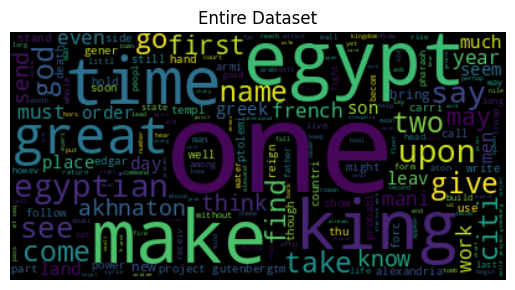

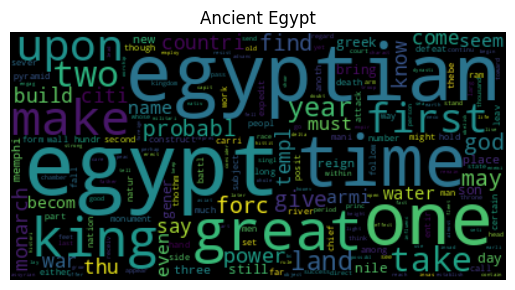

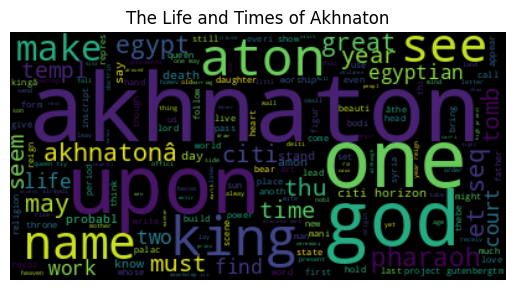

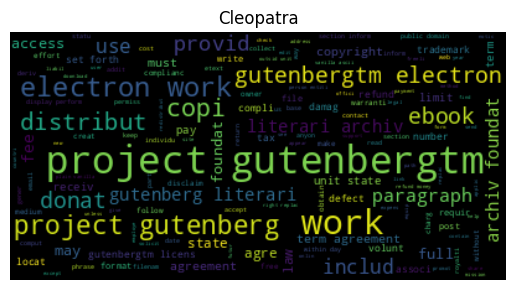

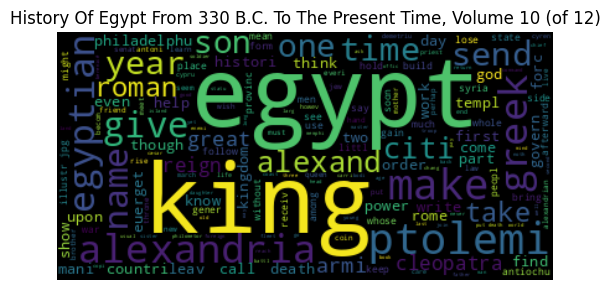

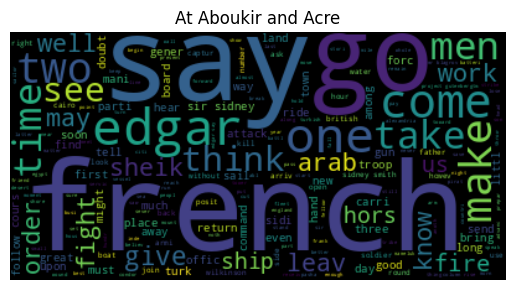

In [5]:
def generate_word_cloud(_df, title):
    # Combine all the words from the specified column in the DataFrame into a single string
    all_words = ' '.join(_df['text'])

    # Create a word cloud object
    wordcloud = WordCloud().generate(all_words)

    # Display the word cloud using matplotlib
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


generate_word_cloud(df, title='Entire Dataset')
# generate one for each book
for title in df['title'].unique():
    generate_word_cloud(df[df['title'] == title], title)

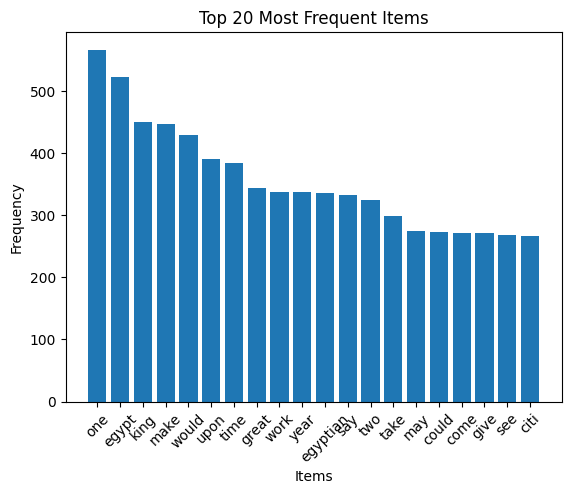

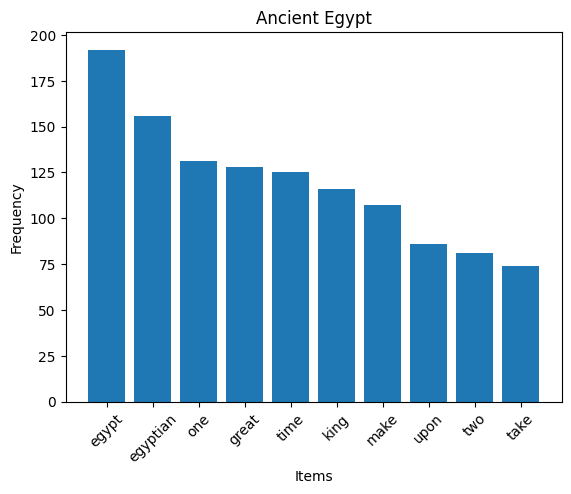

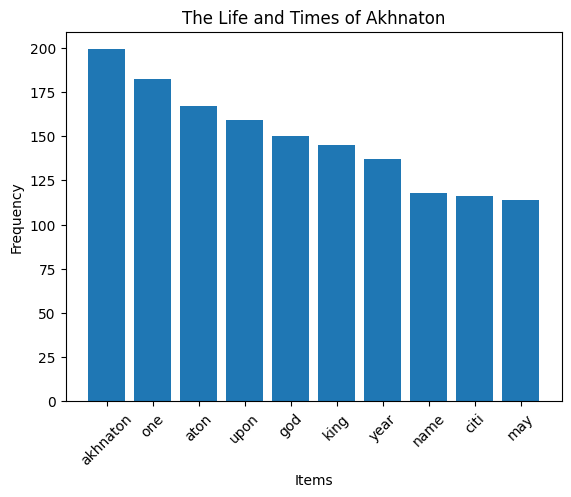

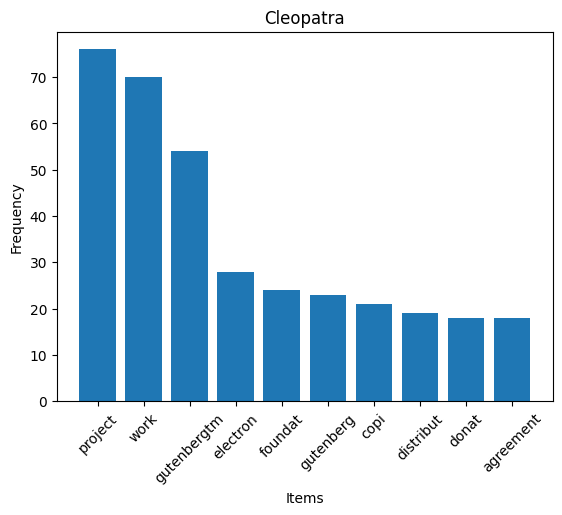

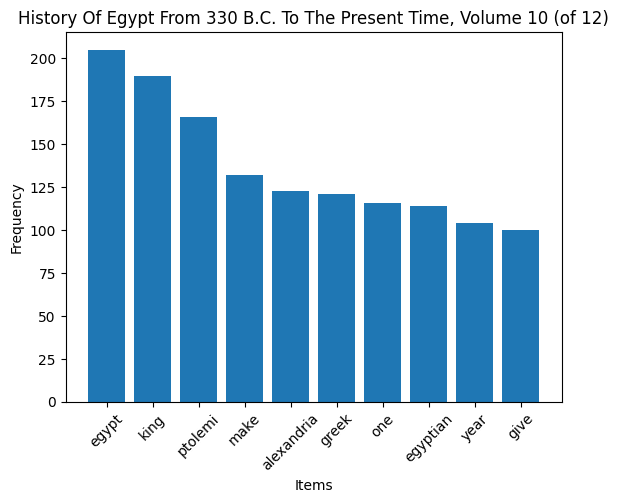

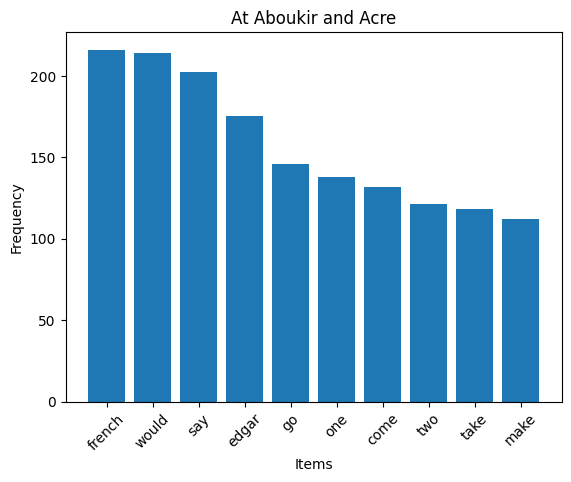

In [6]:
def generate_bar_chart(_df, title, top_n=10):
    """
    show the top N most frequent words in the entire dataset.

    :param _df:
    :param top_n:
    :return:
    """
    # Calculate the frequency of each item in the specified column of the DataFrame
    freq = _df['words'].explode().value_counts().head(top_n)

    # Select the top N most frequent items
    top_items = freq.head(top_n)

    # Create a bar chart
    plt.bar(top_items.index, top_items.values)
    plt.xlabel('Items')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45)

    plt.show()


generate_bar_chart(df, 'Top 20 Most Frequent Items', 20)

# generate one for each book
for title in df['title'].unique():
    generate_bar_chart(df[df['title'] == title],title, 10)

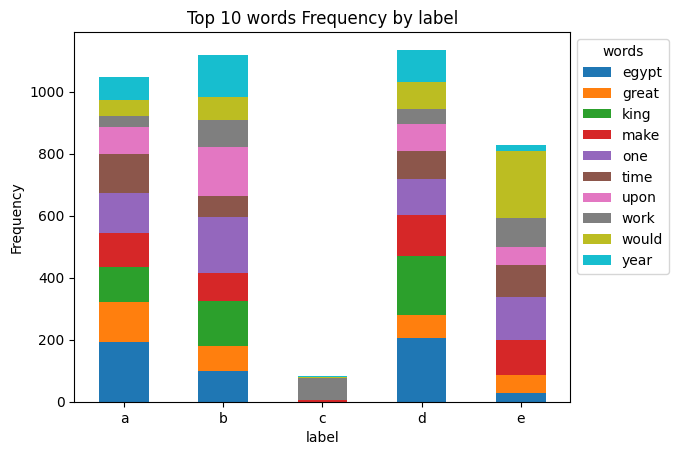

In [7]:
def plot_word_distribution(_df, group_by_col, stacked_col, top_n=10):
    """
    Generate a stacked bar chart to compare the distribution of words among different books.
    Each bar represents a book, and the segments within the bar represent the frequency of different words.

    :param _df: The DataFrame containing the data.
    :param group_by_col: The column name to group the data by to plot into separate bars.
    :param stacked_col: The column name representing the words to plot in the stacked part of the bar chart.
    :param top_n: The number of top words to consider (default: 10).

    :return: None.
    """
    # Explode the column 'stacked_col' to create individual rows for each word
    exploded_df = _df.explode(stacked_col)

    # Get the top N most frequent words
    top_words = exploded_df[stacked_col].value_counts().head(top_n).index

    # Filter the exploded DataFrame to include only the top words
    filtered_df = exploded_df[exploded_df[stacked_col].isin(top_words)]

    # Group the filtered DataFrame by the specified group by column and calculate the frequency of each item per group
    freq_by_group = filtered_df.groupby(group_by_col)[stacked_col].value_counts().unstack()

    # Plot the stacked bar chart
    freq_by_group.plot(kind='bar', stacked=True)
    plt.xlabel(group_by_col)
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} {stacked_col} Frequency by {group_by_col}')

    plt.legend(title=stacked_col, loc='upper left', bbox_to_anchor=(1, 1))
    # plt.tight_layout(rect=[0, 0, 0.100, 1])

    plt.xticks(rotation=0)
    plt.show()


plot_word_distribution(df, 'label', 'words')

# Transformation

In [8]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, LdaModel
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# read pickle file
df = pd.read_pickle('data.pkl')

In [9]:
def get_bow(df):
    vectorizer = CountVectorizer()
    bow = vectorizer.fit_transform(df['text'])
    return bow 


bow_df = get_bow(df.copy())
print(bow_df.shape)

(815, 8742)


In [10]:
def get_tfidf(df):

    vectorizer = TfidfVectorizer()

    tfidf = vectorizer.fit_transform(df['text'])
    return tfidf


tfidf_df = get_tfidf(df.copy())
print(tfidf_df.shape)

(815, 8742)


In [11]:
def get_ngrams(df, ngram_range=(2, 2)):

    vectorizer = CountVectorizer(ngram_range=ngram_range)
    counts = vectorizer.fit_transform(df['text'])
    return counts


grams_df = get_ngrams(df.copy(), (2, 2))
print(grams_df.shape)

(815, 67716)


In [12]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from scipy.sparse import csr_matrix

def get_lda(df, num_topics=5):
    # Create a dictionary representation of the documents
    documents = df['words'].tolist()
    dictionary = Dictionary(documents)

    # Filter out rare and common words
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create a bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Train LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

    # Get the topic distribution for each document
    corpus_lda = lda_model.get_document_topics(corpus)

    # Convert the topic distribution corpus to a sparse matrix
    lda_matrix = corpus2csc(corpus_lda, num_terms=num_topics).T

    return lda_matrix

lda_df = get_lda(df.copy(), 5)
print(lda_df.shape)

(815, 5)


### asd

In [ ]:
# def get_word2vec(_df, vector_size=100, window=5, min_count=1, workers=4):

#     model = Word2Vec(sentences=_df['words'], vector_size=vector_size,
#                      window=window, min_count=min_count, workers=workers)

#     # Get word vectors for each word in each document
#     _df['words'] = _df['words'].apply(lambda words: [model.wv[word] for word in words])

#     return _df


# w2v = get_word2vec(df, 100, 5, 1, 4)

In [ ]:
# import numpy as np 
# def get_doc2vec(df):
#     # Create TaggedDocument objects
#     tagged_docs = [TaggedDocument(words=words, tags=[i]) for i, words in enumerate(df['words'])]

#     # Create a Doc2Vec model
#     model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4)
#     model.build_vocab(tagged_docs)
#     model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

#     df['words'] = df['words'].apply(lambda words: model.infer_vector(words))

#     return df


# doc2vec_df = get_doc2vec(df)

# Cross Validation



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict

In [14]:
def plot_confusion_matrix(cm, classes):

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=list(reversed(classes)))

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# # Generate fake confusion matrix
# num_classes = 6

# cm = np.random.randint(0, 100, size=(num_classes, num_classes))

# # Define class labels
# classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# # Plot confusion matrix
# plot_confusion_matrix(cm, classes)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def cross_validation(model, x, y, x_test, y_test, cv=10):
    """
    this function is used to perform cross validation on the model

    :param model: The model to be cross-validated.
    :param x: the data to be used for training
    :param y: the target variable
    :param cv: the number of folds to be used for cross validation

    :return: dict, A dictionary containing the following keys:
            - Training Accuracy scores
            - Mean Training Accuracy
            - Training Precision scores
            - Mean Training Precision
            - Training Recall scores
            - Mean Training Recall
            - Training F1 scores
            - Mean Training F1 Score
            - Validation Accuracy scores
            - Mean Validation Accuracy
            - Validation Precision scores
            - Mean Validation Precision
            - Validation Recall scores
            - Mean Validation Recall
            - Validation F1 scores
            - Mean Validation F1 Score

    """
    scoring = {'accuracy': 'accuracy',
            'precision': 'precision_macro',
            'recall': 'recall_macro',
            'f1': 'f1_macro'}
            
    results = cross_validate(estimator=model,
                             X=x,
                             y=y,
                             cv=cv,
                             verbose=1,
                             scoring=scoring,
                             return_train_score=True)

    # Calculate the confusion matrix for each fold
    confusion_matrices = []
    accuracy_scoress = []
    for i in range(cv):
        y_pred = cross_val_predict(model, x_test, y_test, cv=cv)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
        accuracy_scoress.append(acc)

    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrices[0], classes=np.unique(y))

    return {"Training Accuracy scores": results['train_accuracy'],
            "Mean Training Accuracy": results['train_accuracy'].mean() * 100,
            "Training Precision scores": results['train_precision'],
            "Mean Training Precision": results['train_precision'].mean(),
            "Training Recall scores": results['train_recall'],
            "Mean Training Recall": results['train_recall'].mean(),
            "Training F1 scores": results['train_f1'],
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Validation Accuracy scores": results['test_accuracy'],
            "Mean Validation Accuracy": results['test_accuracy'].mean() * 100,
            "Validation Precision scores": results['test_precision'],
            "Mean Validation Precision": results['test_precision'].mean(),
            "Validation Recall scores": results['test_recall'],
            "Mean Validation Recall": results['test_recall'].mean(),
            "Validation F1 scores": results['test_f1'],
            "Mean Validation F1 Score": results['test_f1'].mean(),
            "Confusion Matrices": confusion_matrices,
            "Accuracy Scores": accuracy_scoress
            }

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def plot_result(x_label, y_label, plot_title, train_data, val_data, y_ticks_range=0.1):
    """
    Plots a grouped bar chart showing the training and validation results of an ML model
    in each fold after applying K-fold cross-validation.

    :param x_label: str - Name of the algorithm used for training.
    :param y_label: str - Name of the metric being visualized.
    :param plot_title: str - Title of the plot.
    :param train_data: List - List containing the training precision, accuracy, or F1 score for each fold.
    :param val_data:  List - List containing the validation precision, accuracy, or F1 score for each fold.
    :param y_ticks_range: float - Range of the y-axis.

    :return: None
        The function displays a grouped bar chart showing the training and validation results
        in each fold.
    """

    # Set the size of the plot
    plt.figure(figsize=(12, 6))

    # Define labels for each fold
    labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold",
              "6th Fold", "7th Fold", "8th Fold", "9th Fold", "10th Fold"]

    # Create x-axis positions
    X_axis = np.arange(len(labels))

    # set width of bar
    bar_width = 0.4

    # Plot the training and validation data
    plt.bar(X_axis - bar_width / 2, train_data, bar_width, color='blue', label='Training')
    plt.bar(X_axis + bar_width / 2, val_data, bar_width, color='red', label='Validation')

    # Set the plot title, x-label, and y-label
    plt.title(plot_title, fontsize=30)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    # Set the x-axis and y-axis labels and tick positions
    plt.xticks(X_axis, labels)
    plt.yticks(np.arange(0, 1.1, y_ticks_range))

    # Add a legend, grid, and display the plot
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Test the function
# train_data = [0.85, 0.92, 0.88, 0.91, 0.89, 0.90, 0.87, 0.88, 0.90, 0.91]
# val_data = [0.79, 0.81, 0.84, 0.82, 0.83, 0.80, 0.81, 0.82, 0.83, 0.82]

# plot_result("KNN", "Accuracy", "Model Performance", train_data, val_data, 0.1)

In [17]:
def plot_accuracy(train_scores, test_scores, title):
    # Calculate the mean of the training accuracy and testing accuracy
    train_mean = np.mean(train_scores)
    test_mean = np.mean(test_scores)

    # Plotting the training accuracy and testing accuracy as a 2-bar chart
    labels = ['Training Accuracy', 'Testing Accuracy']
    scores = [train_mean, test_mean]

    # Set the position of the bars on the x-axis
    bar_width = 0.35
    ind = np.arange(2)

    # Create the grouped bar chart
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, [train_mean, test_mean], bar_width, label='Mean Accuracy')

        # Add value labels on top of each bar
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

    plt.bar(labels, scores)
    plt.title(title)
    plt.ylabel('Accuracy Scores')
    plt.show()

# plot_accuracy(result_svm_bow['Training Accuracy scores'], result_svm_bow['Accuracy Scores'], "SVM Performance with BOW")


# BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.read_pickle('data.pkl')

# Define the mapping from values to numbers
mapping = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}

# Use replace to convert the values
df['label'] = df['label'].replace(mapping)
# Prepare your data (replace with your own data)
texts = df['text'].tolist()
labels = df['label'].tolist()

In [ ]:
# Tokenize the texts
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Convert lists to tensors
input_ids = torch.tensor(encoded_inputs['input_ids'])
labels = torch.tensor(labels)

# Create dataset
dataset = TensorDataset(input_ids, labels)

# Define number of folds for cross-validation
n_splits = 5

# Initialize cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

<ipython-input-5-eaed7e73d465>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded_inputs['input_ids'])


In [ ]:
# Initialize lists to store evaluation metrics for each fold
fold_losses = []
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

In [ ]:
# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}:")

    # Split data into train and test sets for the current fold
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)

    # Create data loaders for train and test sets
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Load pre-trained BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

    # Set device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define optimizer and learning rate
    optimizer = AdamW(model.parameters(), lr=2e-5)


    # Training loop
    for epoch in range(5):
        model.train()
        for batch_inputs, batch_labels in train_dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(input_ids=batch_inputs, labels=batch_labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation on test set
    model.eval()
    test_loss = 0
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for batch_inputs, batch_labels in test_dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(input_ids=batch_inputs, labels=batch_labels)
            test_loss += outputs.loss.item()
            test_predictions.extend(outputs.logits.argmax(dim=1).cpu().tolist())
            test_labels.extend(batch_labels.cpu().tolist())

    test_loss /= len(test_dataloader)

    # Calculate evaluation metrics for the current fold
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions, average='weighted')
    test_recall = recall_score(test_labels, test_predictions, average='weighted')
    test_f1 = f1_score(test_labels, test_predictions, average='weighted')

    # Print evaluation metrics for the current fold
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test F1 Score:", test_f1)

    # Store evaluation metrics for the current fold
    fold_losses.append(test_loss)
    fold_accuracies.append(test_accuracy)
    fold_precisions.append(test_precision)
    fold_recalls.append(test_recall)
    fold_f1_scores.append(test_f1)


Fold 1:


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Test Loss: 0.19537752677154327
Test Accuracy: 0.9406392694063926
Test Precision: 0.9432236162452089
Test Recall: 0.9406392694063926
Test F1 Score: 0.9395812209366644
Fold 2:


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Test Loss: 0.12735908535043045
Test Accuracy: 0.958904109589041
Test Precision: 0.9616686857391359
Test Recall: 0.958904109589041
Test F1 Score: 0.9585696541511103
Fold 3:


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Test Loss: 0.2509339719877711
Test Accuracy: 0.9174311926605505
Test Precision: 0.9241112644391973
Test Recall: 0.9174311926605505
Test F1 Score: 0.9168426838033231
Fold 4:


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Test Loss: 0.27593425631390084
Test Accuracy: 0.9128440366972477
Test Precision: 0.9293120638085742
Test Recall: 0.9128440366972477
Test F1 Score: 0.9114515083206631
Fold 5:


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Test Loss: 0.20952537436304347
Test Accuracy: 0.944954128440367
Test Precision: 0.948063730632538
Test Recall: 0.944954128440367
Test F1 Score: 0.9458395688118391


In [ ]:
# Print average evaluation metrics across all folds
print("\nAverage Evaluation Metrics:")
print("Average Test Loss:", sum(fold_losses) / n_splits)
print("Average Test Accuracy:", sum(fold_accuracies) / n_splits)
print("Average Test Precision:", sum(fold_precisions) / n_splits)
print("Average Test Recall:", sum(fold_recalls) / n_splits)
print("Average Test F1 Score:", sum(fold_f1_scores) / n_splits)


Average Evaluation Metrics:
Average Test Loss: 0.2118260429573378
Average Test Accuracy: 0.9349545473587197
Average Test Precision: 0.941275872172931
Average Test Recall: 0.9349545473587197
Average Test F1 Score: 0.9344569272047198


## without cross validation

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00


In [ ]:
# Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.read_pickle('data.pkl')

# Define the mapping from values to numbers
mapping = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5}

# Use replace to convert the values
df['label'] = df['label'].replace(mapping)
# Prepare your data (replace with your own data)
texts = df['text'].tolist()
labels = df['label'].tolist()

In [ ]:

# Tokenize the texts
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Split the data into train, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

In [ ]:
# Tokenize the train, validation, and test texts
train_inputs = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
val_inputs = tokenizer(val_texts, padding=True, truncation=True, return_tensors='pt')
test_inputs = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt')

# Convert lists to tensors
input_ids_train = torch.tensor(train_inputs['input_ids'])
labels_train = torch.tensor(train_labels)
input_ids_val = torch.tensor(val_inputs['input_ids'])
labels_val = torch.tensor(val_labels)
input_ids_test = torch.tensor(test_inputs['input_ids'])
labels_test = torch.tensor(test_labels)

<ipython-input-5-6ff9793bc9ff>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_train = torch.tensor(train_inputs['input_ids'])
<ipython-input-5-6ff9793bc9ff>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_val = torch.tensor(val_inputs['input_ids'])
<ipython-input-5-6ff9793bc9ff>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_test = torch.tensor(test_inputs['input_ids'])


In [ ]:
# Create data loaders
train_dataset = TensorDataset(input_ids_train, labels_train)
val_dataset = TensorDataset(input_ids_val, labels_val)
test_dataset = TensorDataset(input_ids_test, labels_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Training loop
for epoch in range(5):
    model.train()
    for batch_inputs, batch_labels in train_dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(input_ids=batch_inputs, labels=batch_labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
# Evaluation on validation set
model.eval()
val_loss = 0
val_predictions = []
with torch.no_grad():
    for batch_inputs, batch_labels in val_dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(input_ids=batch_inputs, labels=batch_labels)
        val_loss += outputs.loss.item()
        val_predictions.extend(outputs.logits.argmax(dim=1).cpu().tolist())

val_loss /= len(val_dataloader)

In [ ]:
# Evaluation on test set
test_loss = 0
test_predictions = []
with torch.no_grad():
    for batch_inputs, batch_labels in test_dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(input_ids=batch_inputs, labels=batch_labels)
        test_loss += outputs.loss.item()
        test_predictions.extend(outputs.logits.argmax(dim=1).cpu().tolist())

test_loss /= len(test_dataloader)

print("Validation Loss:", val_loss)
print("Test Loss:", test_loss)
print("Validation Predictions:", val_predictions)
print("Test Predictions:", test_predictions)

Validation Loss: 0.2233937568962574
Test Loss: 0.22986729057239635
Validation Predictions: [2, 0, 4, 3, 0, 2, 1, 0, 1, 5, 2, 4, 3, 2, 2, 2, 4, 4, 4, 2, 5, 1, 5, 0, 5, 3, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0, 5, 4, 4, 4, 3, 5, 4, 1, 2, 5, 4, 5, 5, 0, 2, 2, 4, 0, 2, 3, 0, 2, 0, 1, 1, 0, 5, 3, 0, 4, 4, 3, 3, 4, 3, 2, 4, 5, 3, 1, 1, 3, 2, 1, 1, 3, 2, 3, 5, 0, 1, 2, 0, 4, 1, 2, 2, 4, 2, 1, 5, 1, 1, 2, 2, 0, 2, 0, 5, 3, 1, 2, 2, 2, 0, 2, 5, 2, 3, 1, 1, 0, 1, 3, 5, 2, 4, 5, 2, 0, 5, 4, 0, 0, 5, 3, 2, 2, 2, 4, 1, 0, 3, 5, 0, 5, 5, 1, 4, 5, 1, 0, 5, 0, 5, 4, 1, 1, 5, 1, 0, 0, 3, 1, 5, 0, 5, 4, 0, 4, 1, 4, 2, 4, 2, 3, 2, 2, 1]
Test Predictions: [2, 0, 0, 4, 4, 4, 1, 0, 5, 4, 5, 4, 4, 2, 0, 5, 2, 2, 3, 4, 2, 1, 0, 0, 0, 4, 1, 1, 0, 0, 1, 3, 4, 0, 0, 5, 5, 4, 1, 5, 0, 5, 5, 4, 4, 0, 4, 1, 2, 4, 3, 1, 1, 5, 4, 2, 0, 3, 2, 4, 1, 0, 5, 4, 1, 0, 2, 2, 1, 1, 2, 5, 5, 3, 4, 4, 1, 4, 1, 5, 5, 2, 1, 2, 2, 1, 2, 4, 4, 3, 2, 5, 0, 0, 1, 5, 5, 4, 1, 2, 0, 1, 4, 2, 1, 2, 5, 1, 4, 0, 1, 4, 0, 5, 0, 1, 5, 5, 2, 0, 1, 2

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation on test set
model.eval()
test_loss = 0
test_predictions = []
with torch.no_grad():
    for batch_inputs, batch_labels in test_dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(input_ids=batch_inputs, labels=batch_labels)
        test_loss += outputs.loss.item()
        test_predictions.extend(outputs.logits.argmax(dim=1).cpu().tolist())

test_loss /= len(test_dataloader)

# Calculate evaluation metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
test_f1 = f1_score(test_labels, test_predictions, average='weighted')

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Test Loss: 0.22986729057239635
Test Accuracy: 0.9315068493150684
Test Precision: 0.9341752733554453
Test Recall: 0.9315068493150684
Test F1 Score: 0.9315139991099861


# Models

## Ali

In [18]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

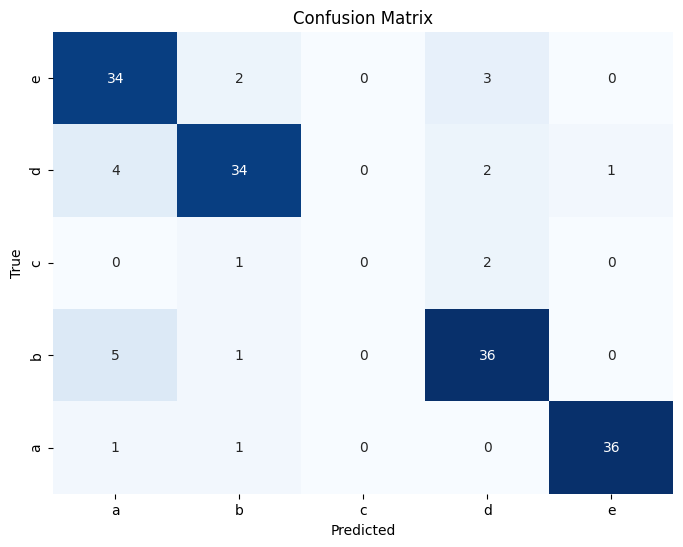

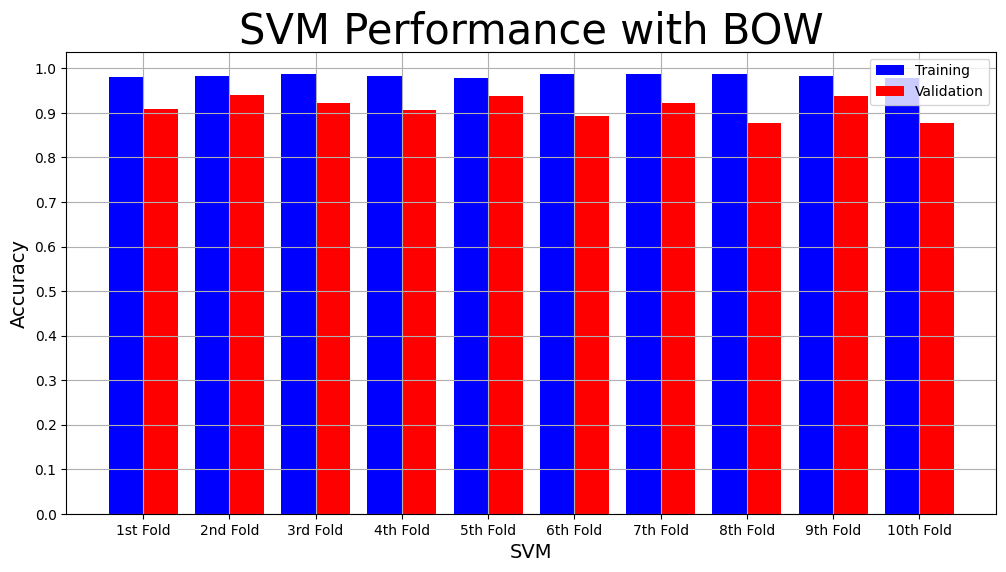

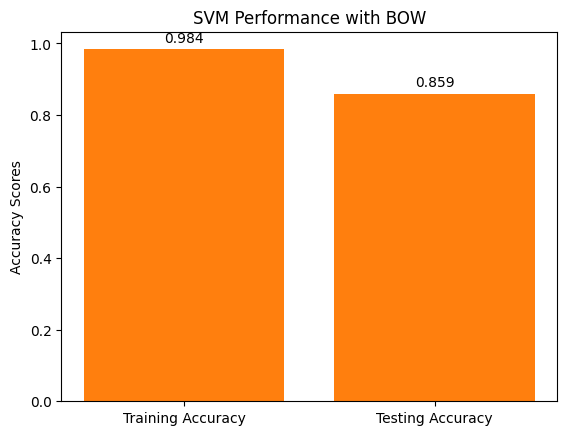

In [68]:
def svm_bow():
  # Train SVM model on training set and evaluate performance on testing set
  clf = SVC(kernel='rbf', C=1, random_state=42)
  result = cross_validation(clf, get_bow(X_train), y_train, get_bow(X_test), y_test, cv=10)

  plot_result("SVM", "Accuracy", "SVM Performance with BOW",
              result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                result['Accuracy Scores'], "SVM Performance with BOW")

  return result
  
result_svm_bow = svm_bow()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

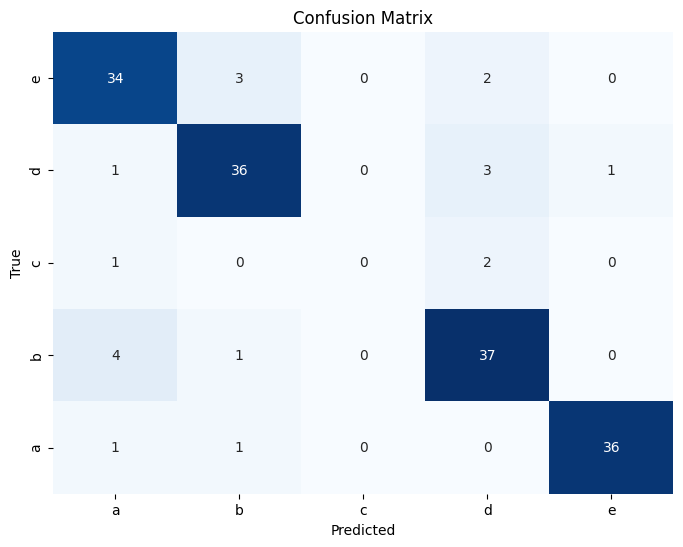

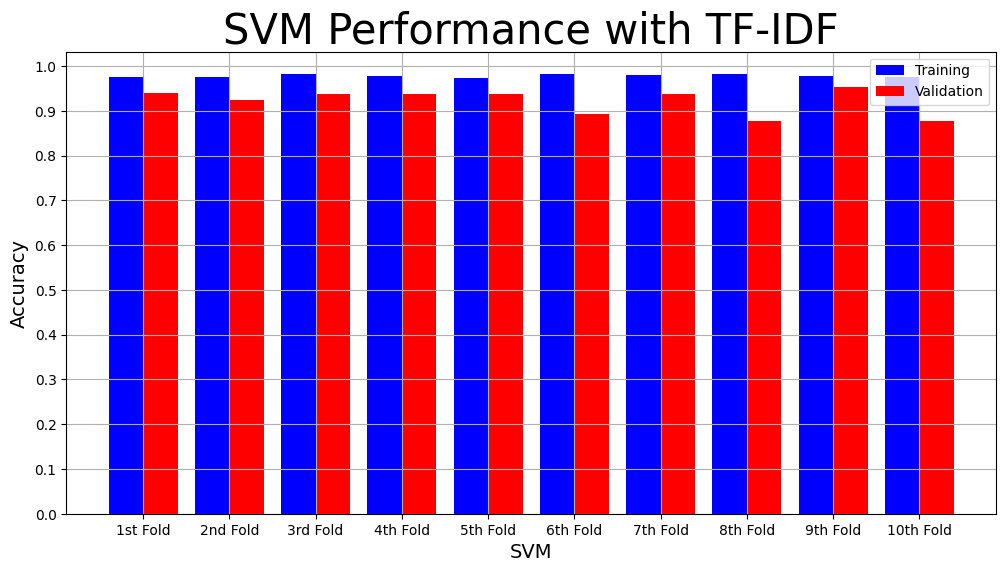

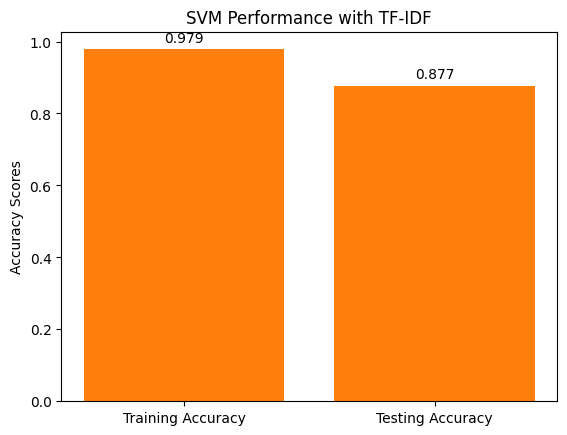

In [24]:
def svm_tfidf():
  # Train SVM model on training set and evaluate performance on testing set
  clf = SVC(kernel='rbf', C=1, random_state=42)
  result = cross_validation(clf, get_tfidf(X_train), y_train, get_tfidf(X_test), y_test, cv=10)

  plot_result("SVM", "Accuracy", "SVM Performance with TF-IDF",
            result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                result['Accuracy Scores'], "SVM Performance with TF-IDF")
  
  return result
  
result_svm_tfidf = svm_tfidf()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

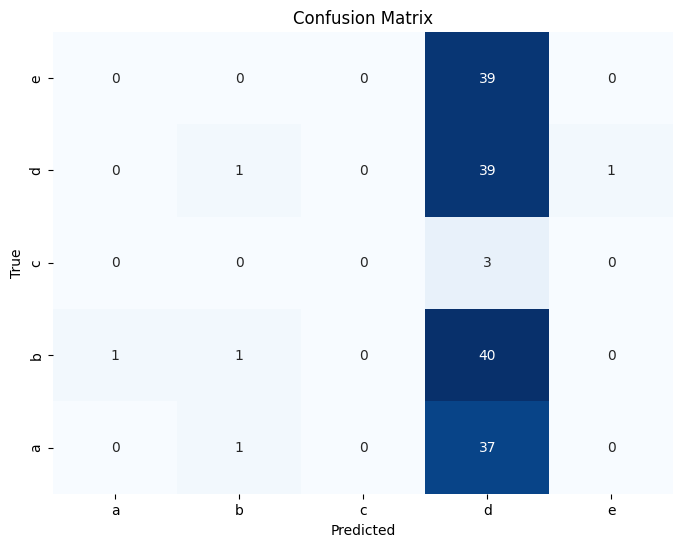

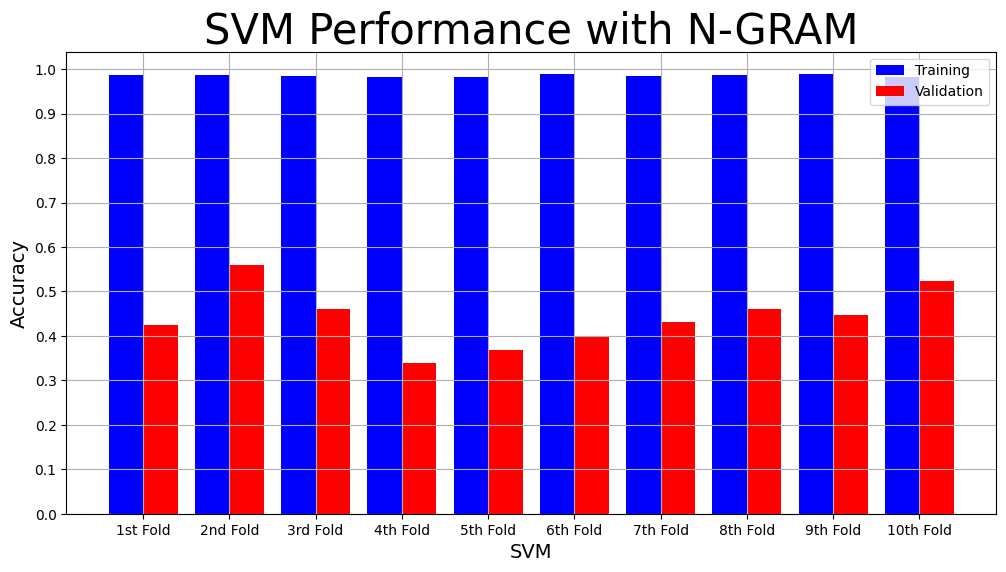

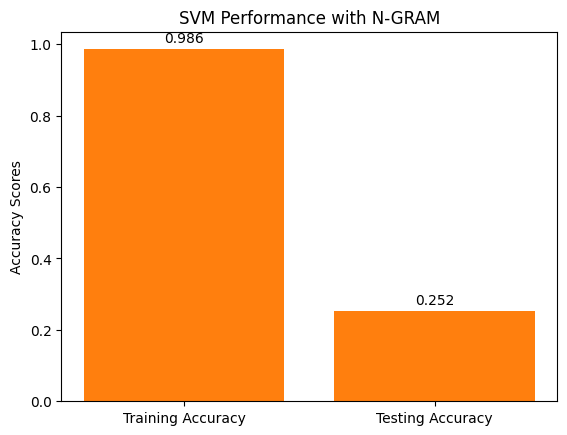

In [25]:
def svm_ngram():
  # Train SVM model on training set and evaluate performance on testing set
  clf = SVC(kernel='rbf', C=1, random_state=42)
  result = cross_validation(clf,get_ngrams(X_train),y_train, get_ngrams(X_test), y_test, cv=10)
  
  plot_result("SVM", "Accuracy", "SVM Performance with N-GRAM",
            result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                    result['Accuracy Scores'], "SVM Performance with N-GRAM")
  
  return result
  
result_svm_ngram = svm_ngram()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

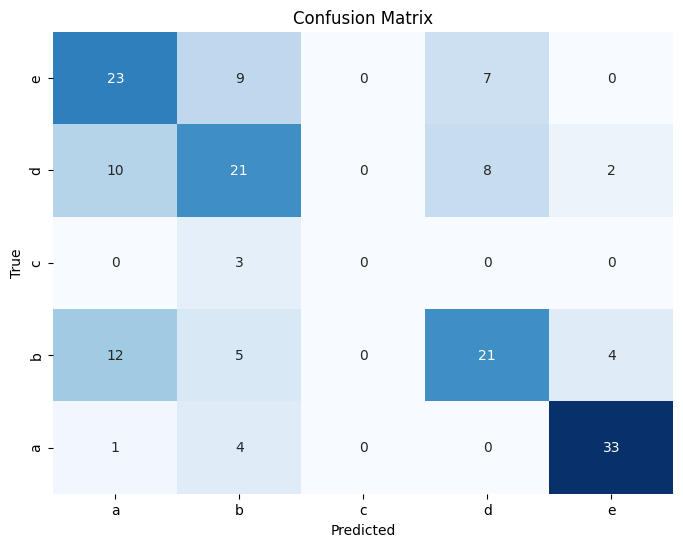

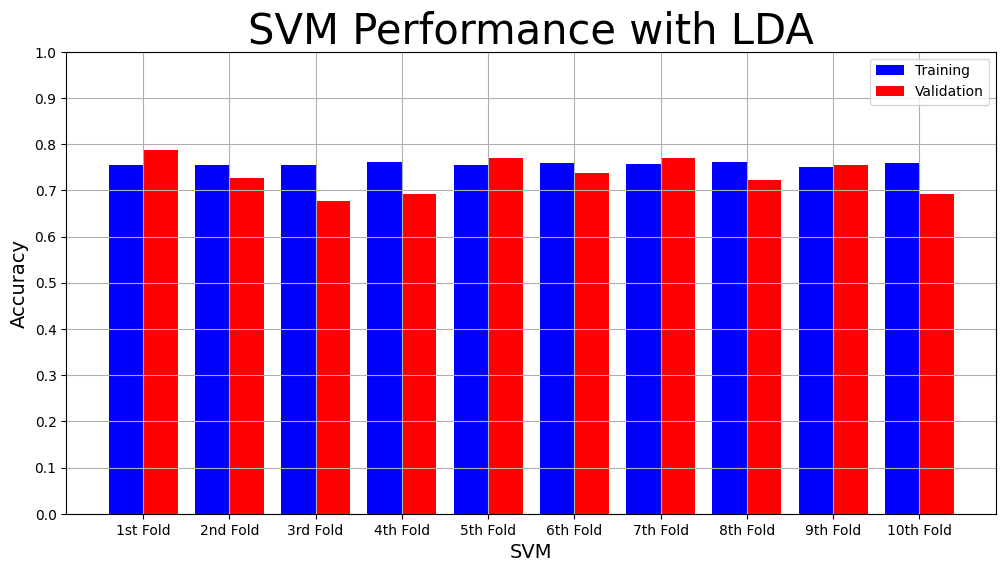

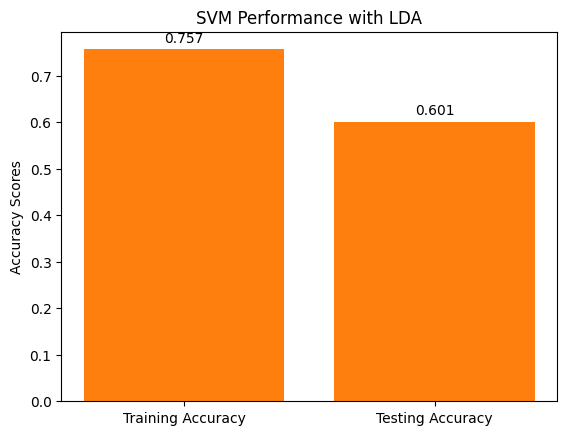

In [26]:
def svm_lda():
  # Train SVM model on training set and evaluate performance on testing set
  clf = SVC(kernel='rbf', C=1, random_state=42)
  result = cross_validation(clf,get_lda(X_train),y_train, get_lda(X_test), y_test, cv=10)

  plot_result("SVM", "Accuracy", "SVM Performance with LDA",
            result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                        result['Accuracy Scores'], "SVM Performance with LDA")

  return result
  
result_svm_lda = svm_lda()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

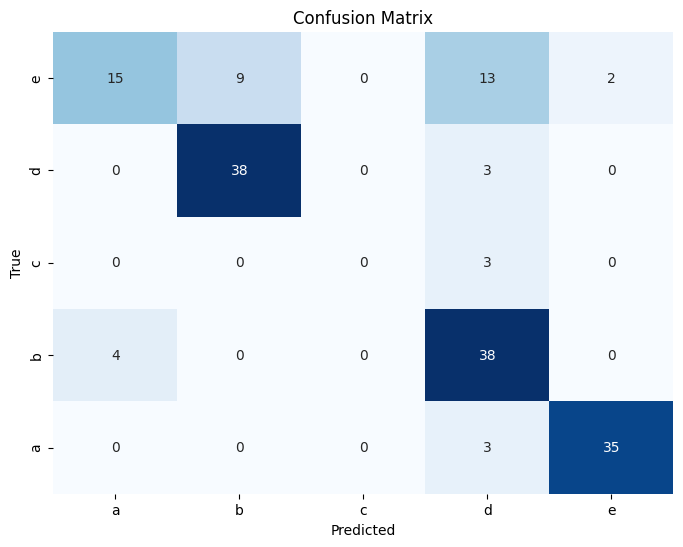

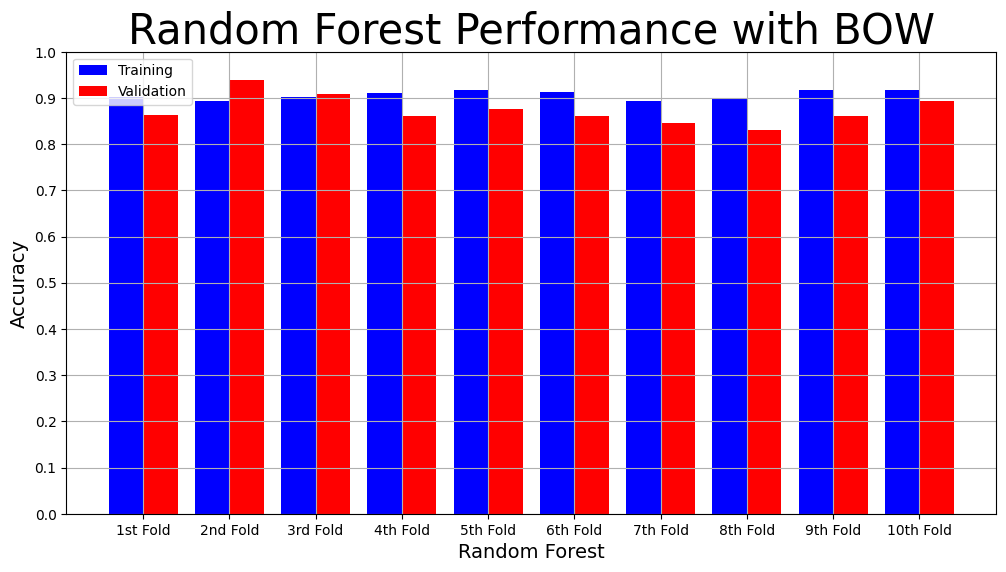

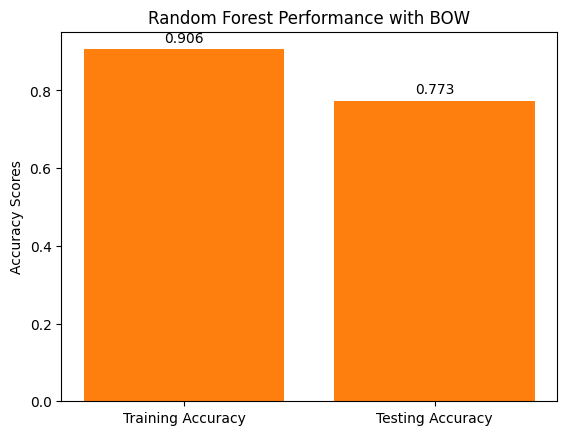

In [27]:
def random_forest_bow():
  rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  result = cross_validation(rfc, get_bow(X_train), y_train, get_bow(X_test), y_test, cv=10)

  plot_result("Random Forest", "Accuracy", "Random Forest Performance with BOW",
              result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                result['Accuracy Scores'], "Random Forest Performance with BOW")
  
  return result

result_random_forest_bow = random_forest_bow()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

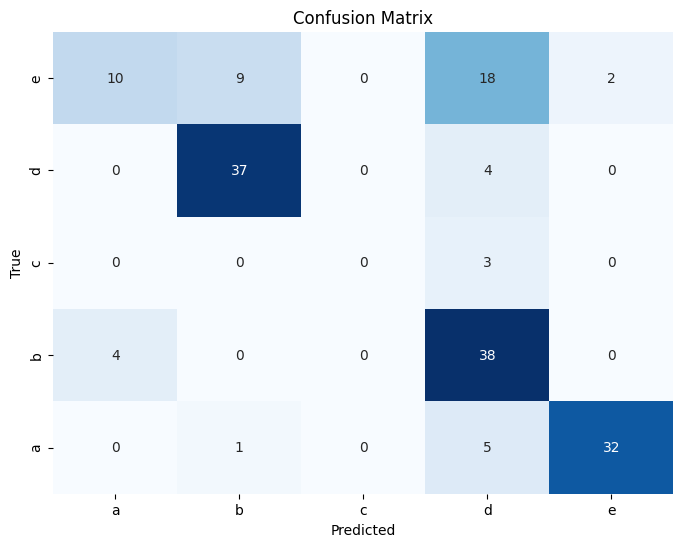

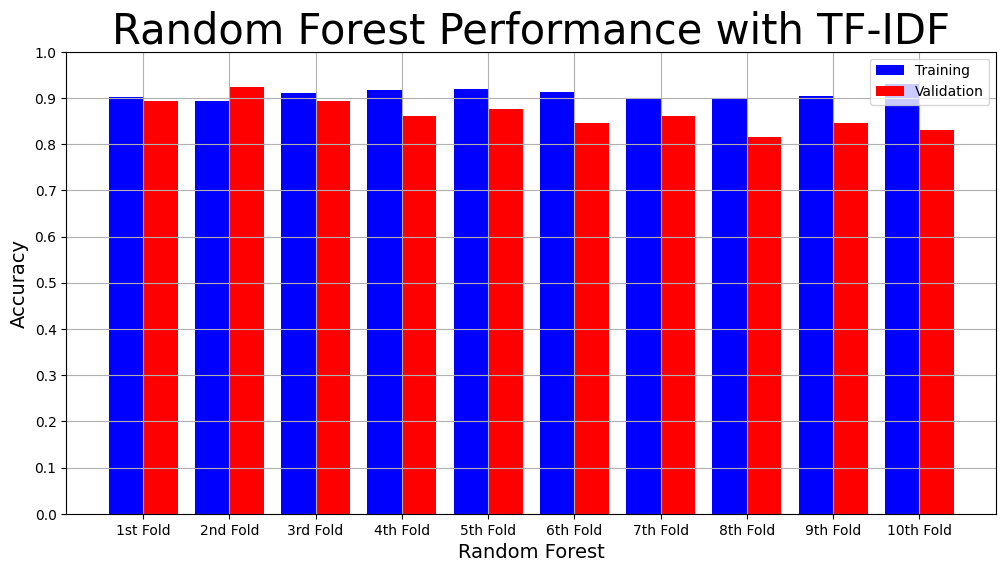

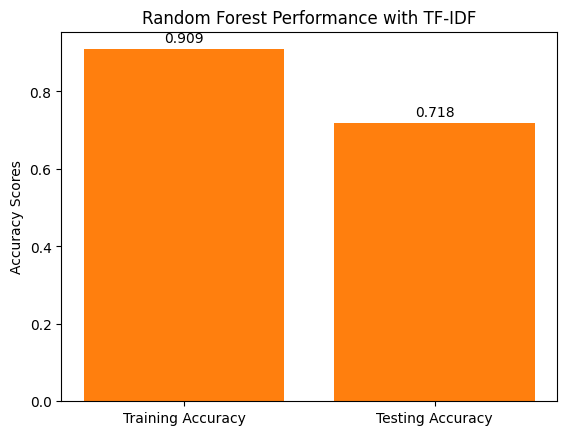

In [28]:
def random_forest_tfidf():
  rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  result = cross_validation(rfc, get_tfidf(X_train), y_train, get_tfidf(X_test), y_test, cv=10)

  plot_result("Random Forest", "Accuracy", "Random Forest Performance with TF-IDF",
              result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                    result['Accuracy Scores'], "Random Forest Performance with TF-IDF")
  
  return result

result_random_forest_tfidf = random_forest_tfidf()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

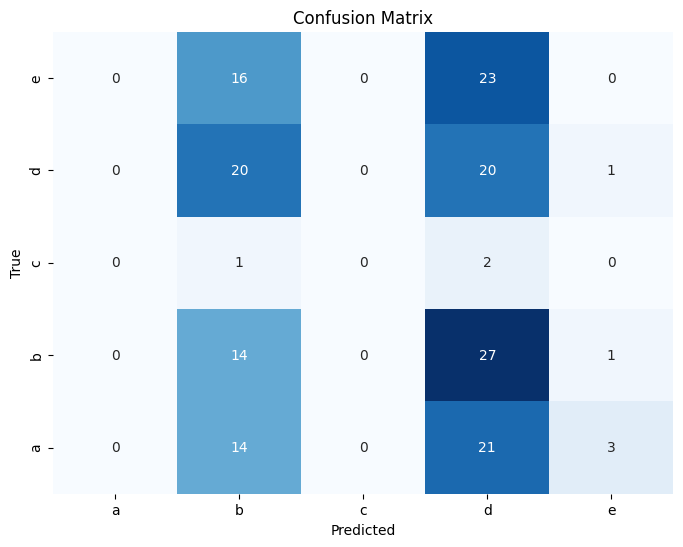

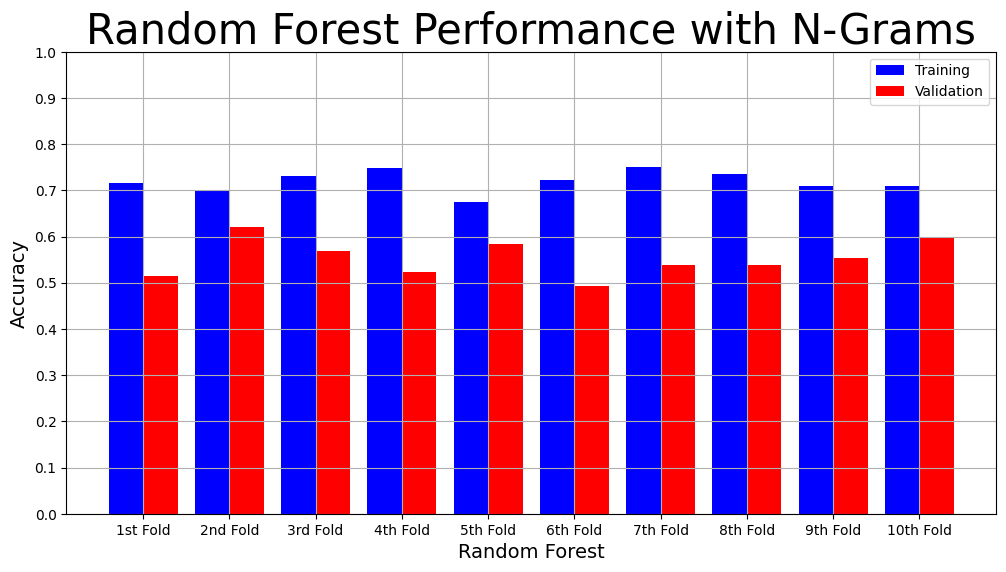

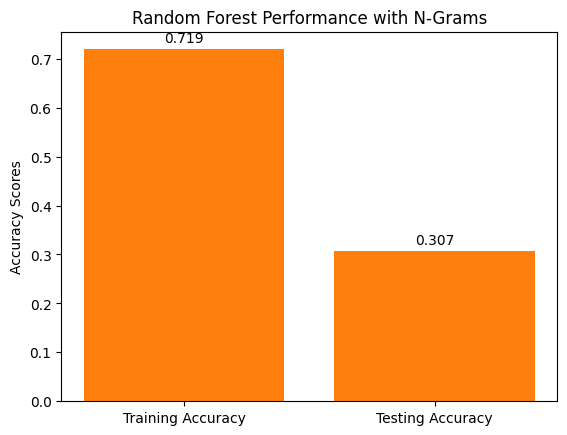

In [29]:
def random_forest_ngrams():
  rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  result = cross_validation(rfc,get_ngrams(X_train),y_train, get_ngrams(X_test), y_test, cv=10)

  plot_result("Random Forest", "Accuracy", "Random Forest Performance with N-Grams",
              result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                        result['Accuracy Scores'], "Random Forest Performance with N-Grams")
  
  return result

result_random=random_forest_ngrams()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

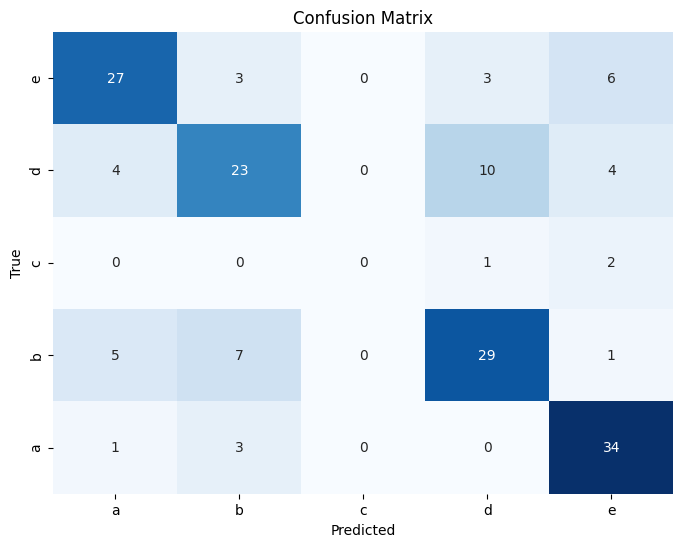

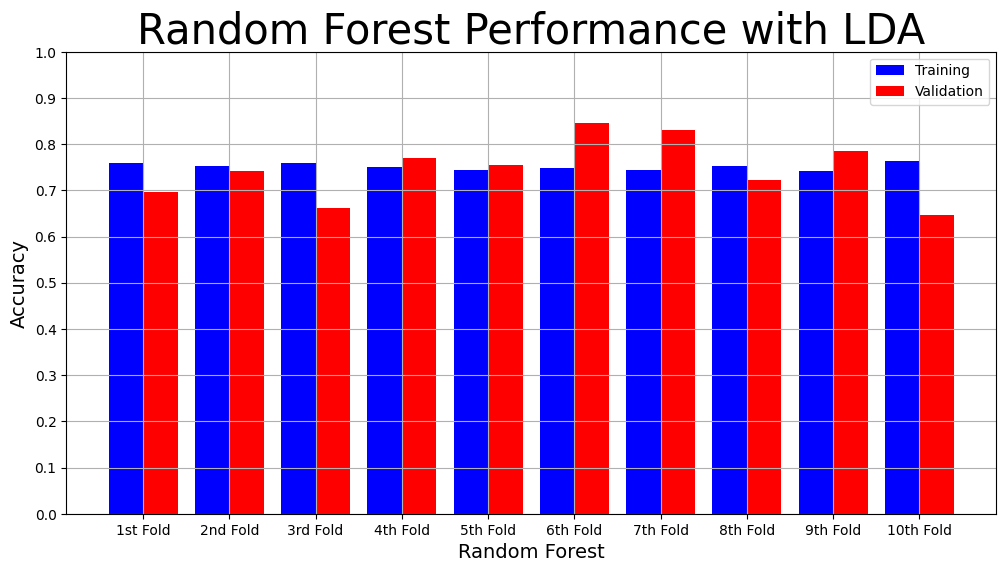

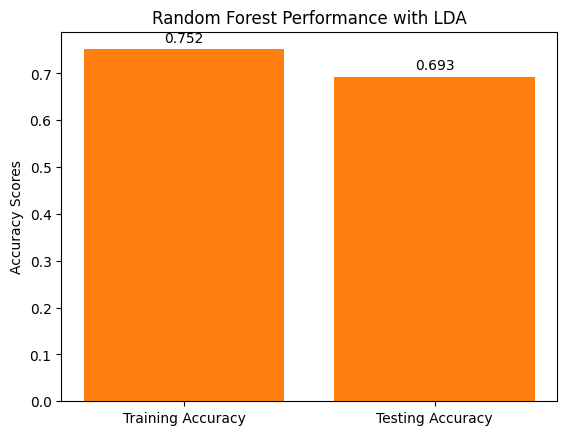

In [30]:
def random_forest_lda():
  rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
  result = cross_validation(rfc,get_lda(X_train),y_train, get_lda(X_test), y_test, cv=10)

  plot_result("Random Forest", "Accuracy", "Random Forest Performance with LDA",
              result['Training Accuracy scores'], result['Validation Accuracy scores'], 0.1)

  plot_accuracy(result['Training Accuracy scores'],
                            result['Accuracy Scores'], "Random Forest Performance with LDA")
  
  return result

result_random_forest_lda = random_forest_lda()

## Aya

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

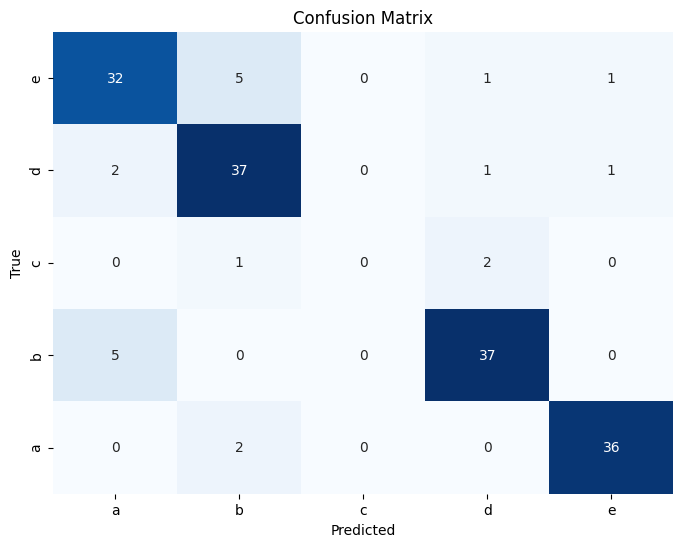

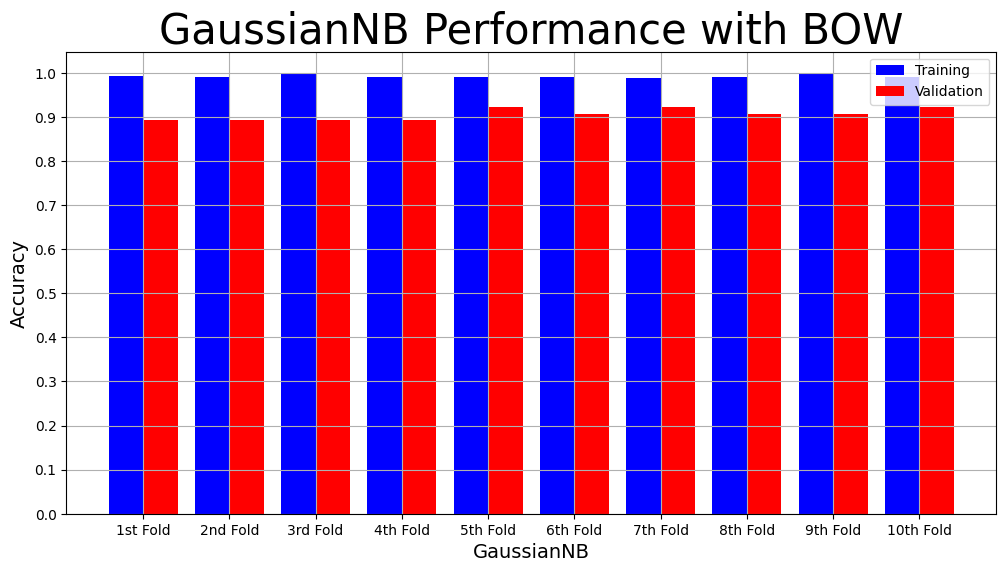

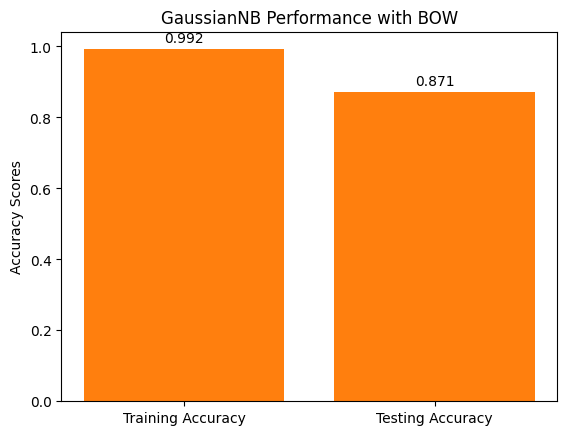

In [44]:
def fit_GaussianNB_with_BOW(df) :
    scores_BOW=cross_validation(GaussianNB(), get_bow(X_train).toarray(), y_train, get_bow(X_test).toarray(), y_test, cv=10)

    plot_result("GaussianNB", "Accuracy", "GaussianNB Performance with BOW", 
                scores_BOW['Training Accuracy scores'], scores_BOW['Validation Accuracy scores'], 0.1)

    plot_accuracy(scores_BOW['Training Accuracy scores'],
                scores_BOW['Accuracy Scores'], "GaussianNB Performance with BOW")
    
    return scores_BOW
 
result_GaussianNB_BOW = fit_GaussianNB_with_BOW(df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

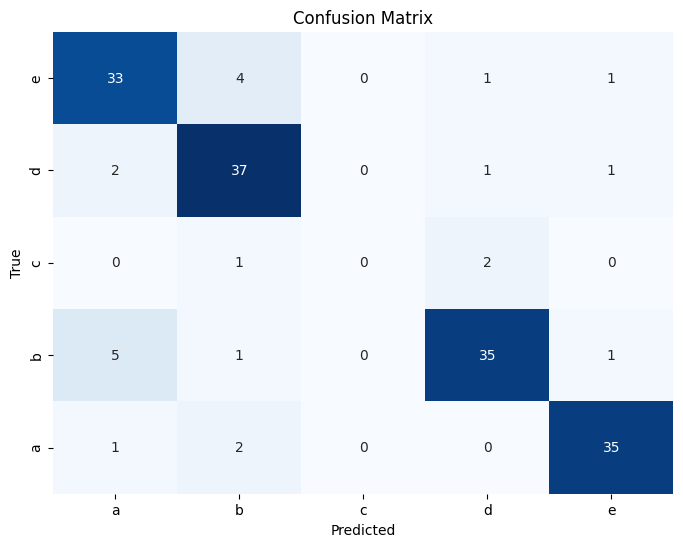

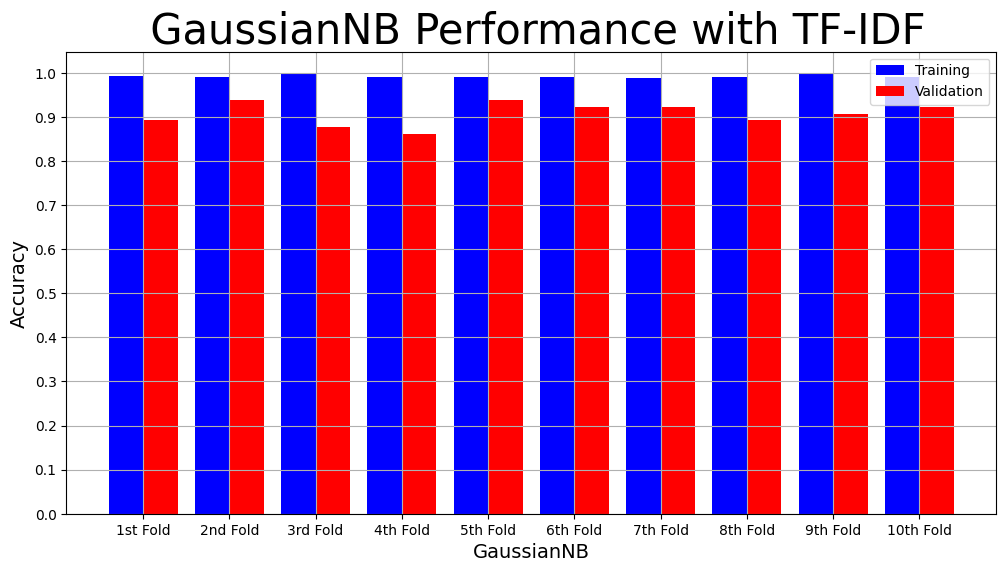

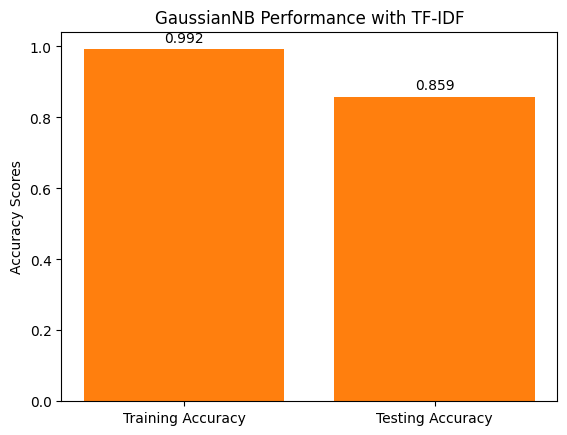

In [45]:
def fit_GaussianNB_with_TFIDF(df) :
    scores_tfidf=cross_validation(GaussianNB(),get_tfidf(X_train).toarray(), y_train, get_tfidf(X_test).toarray(), y_test, cv=10)
    
    plot_result("GaussianNB", "Accuracy", " GaussianNB Performance with TF-IDF", 
                scores_tfidf['Training Accuracy scores'], scores_tfidf['Validation Accuracy scores'], 0.1)

    plot_accuracy(scores_tfidf['Training Accuracy scores'],
                scores_tfidf['Accuracy Scores'], "GaussianNB Performance with TF-IDF")

    return scores_tfidf
 
result_GaussianNB_TFIDF = fit_GaussianNB_with_TFIDF(df)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

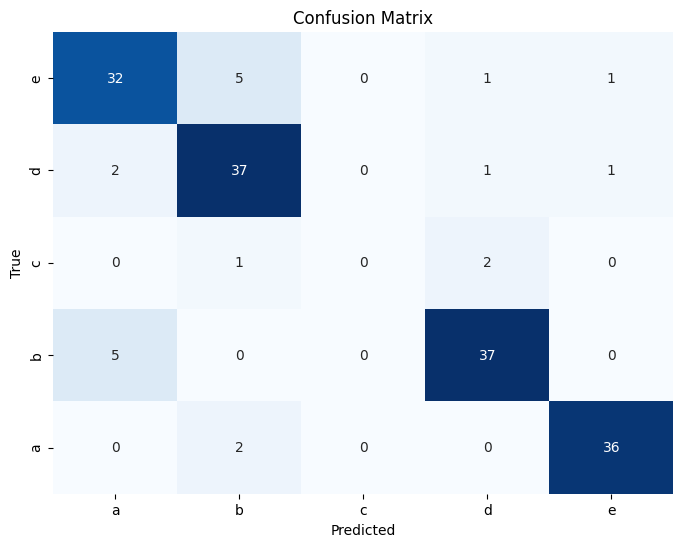

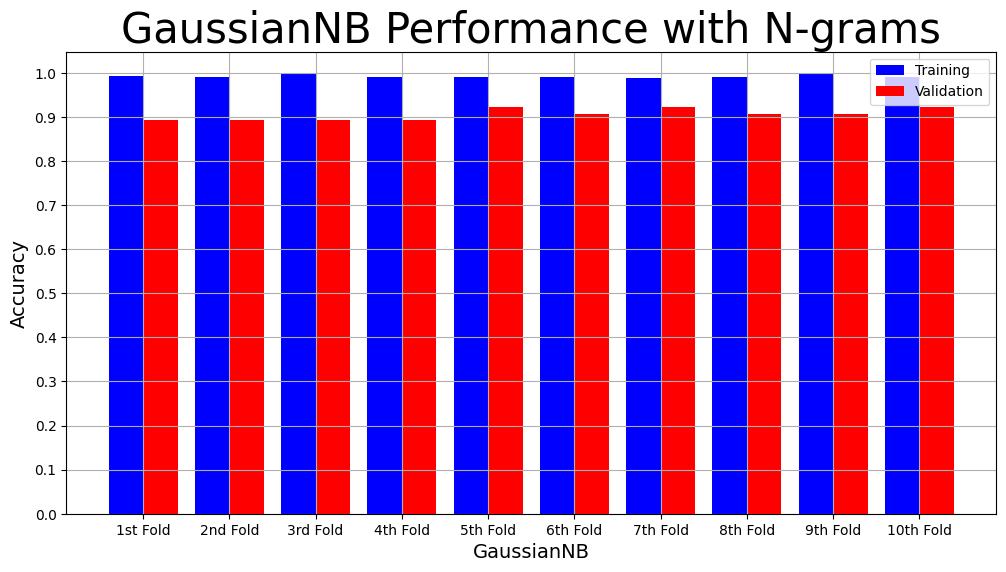

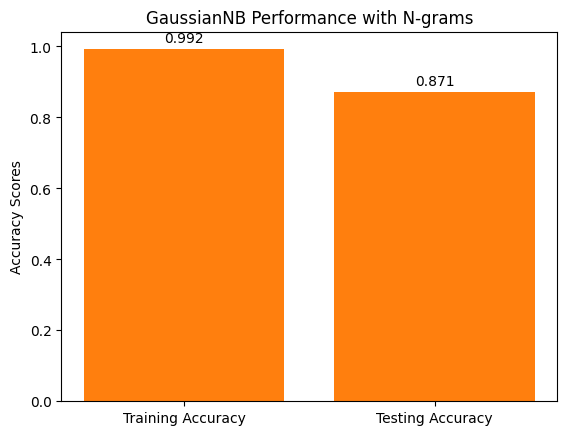

In [47]:
def fit_GaussianNB_with_ngrams(df):
    scores_ngrams=cross_validation(GaussianNB(), get_bow(X_train).toarray(), y_train, get_bow(X_test).toarray(), y_test, cv=10)
    plot_result("GaussianNB", "Accuracy", "GaussianNB Performance with N-grams", 
                scores_ngrams['Training Accuracy scores'], scores_ngrams['Validation Accuracy scores'], 0.1)

    plot_accuracy(scores_ngrams['Training Accuracy scores'],
                scores_ngrams['Accuracy Scores'], "GaussianNB Performance with N-grams")
    
    return scores_ngrams
 

result_GaussianNB_ngrams = fit_GaussianNB_with_ngrams(df)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: Us

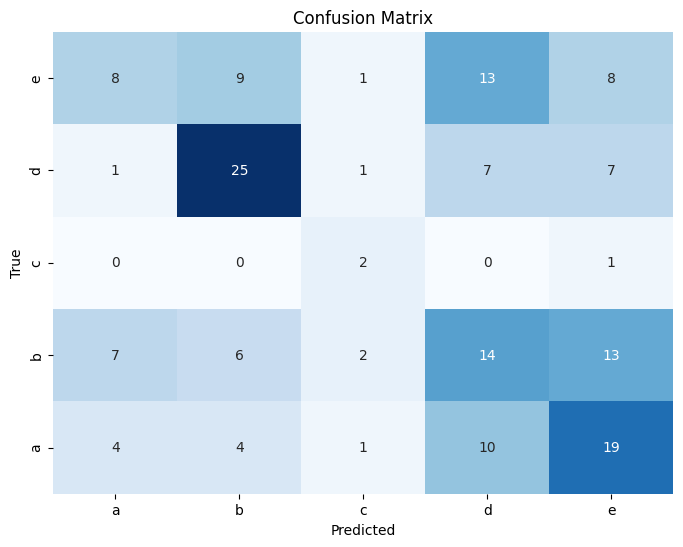

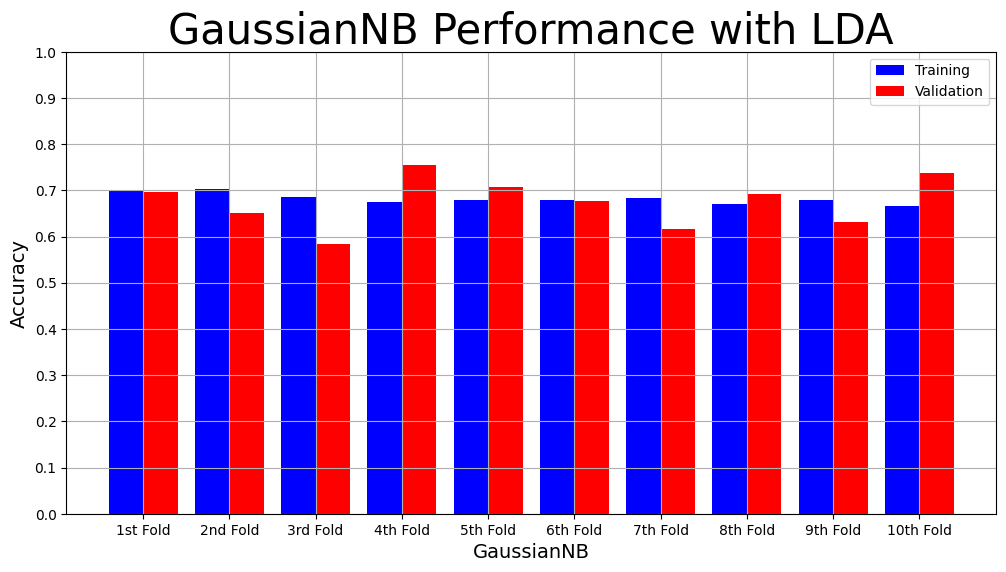

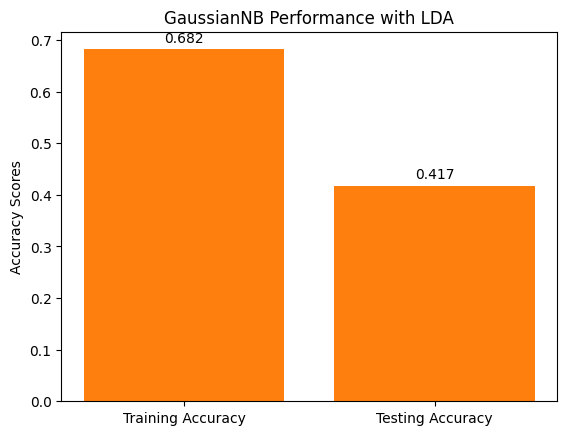

In [48]:
def fit_GaussianNB_with_lda(df):
    lda_scores=cross_validation(GaussianNB(),get_lda(X_train).toarray(),y_train, get_lda(X_test).toarray(), y_test, cv=10)

    plot_result("GaussianNB", "Accuracy", "GaussianNB Performance with LDA", 
                lda_scores['Training Accuracy scores'], lda_scores['Validation Accuracy scores'], 0.1)

    plot_accuracy(lda_scores['Training Accuracy scores'],
                lda_scores['Accuracy Scores'], "GaussianNB Performance with LDA")
    
    return lda_scores
 
 
result_GaussianNB_lda = fit_GaussianNB_with_lda(df)
result_GaussianNB_TFIDF result_GaussianNB_ngrams result_GaussianNB_lda

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: 

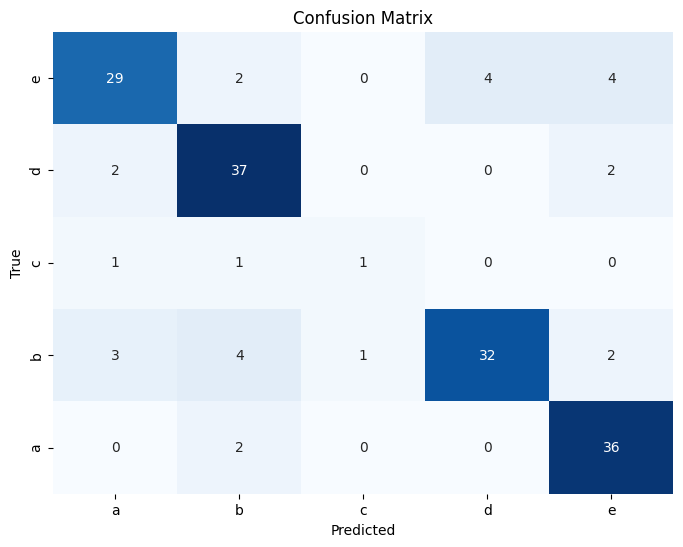

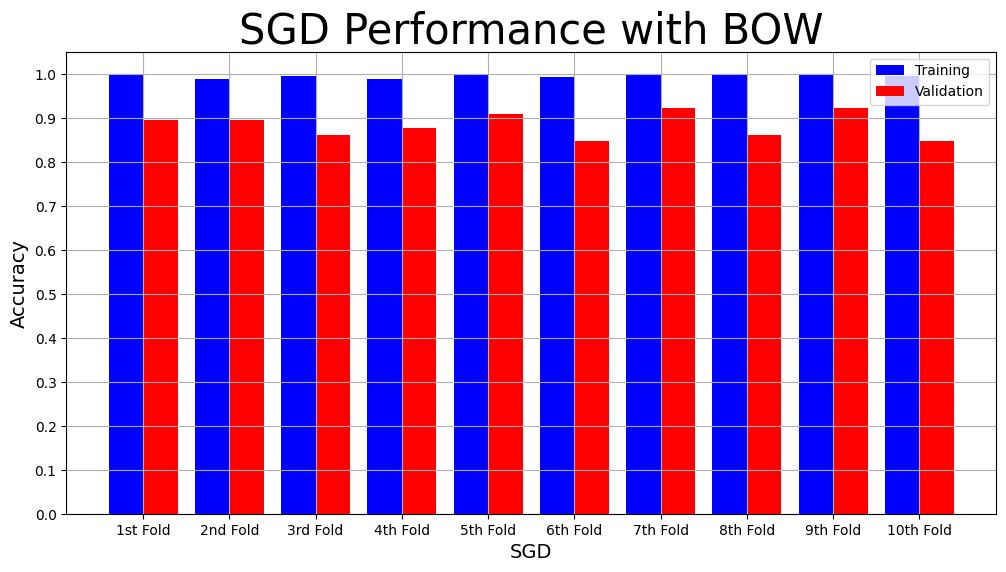

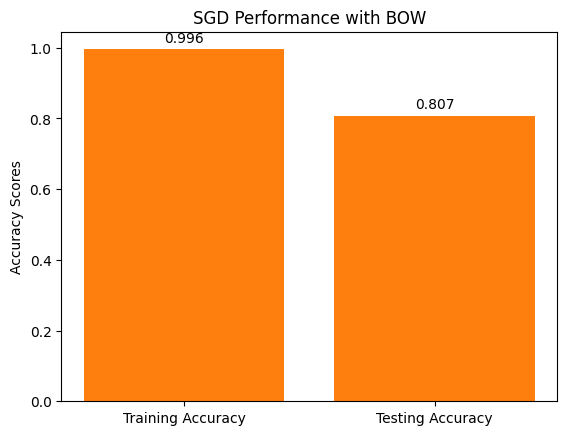

In [38]:
def fit_SGD_with_BOW(df):
    scores_BOW=cross_validation(SGDClassifier(loss='hinge', penalty='l2', alpha=0.001,max_iter=1000), 
                                get_bow(X_train), y_train, get_bow(X_test), y_test, cv=10)
    
    plot_result("SGD", "Accuracy", "SGD Performance with BOW", scores_BOW['Training Accuracy scores'], 
                scores_BOW['Validation Accuracy scores'], 0.1)

    plot_accuracy(scores_BOW['Training Accuracy scores'],
                scores_BOW['Accuracy Scores'], "SGD Performance with BOW")
    
    return scores_BOW
 
 
result_SGD_BOW = fit_SGD_with_BOW(df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selec

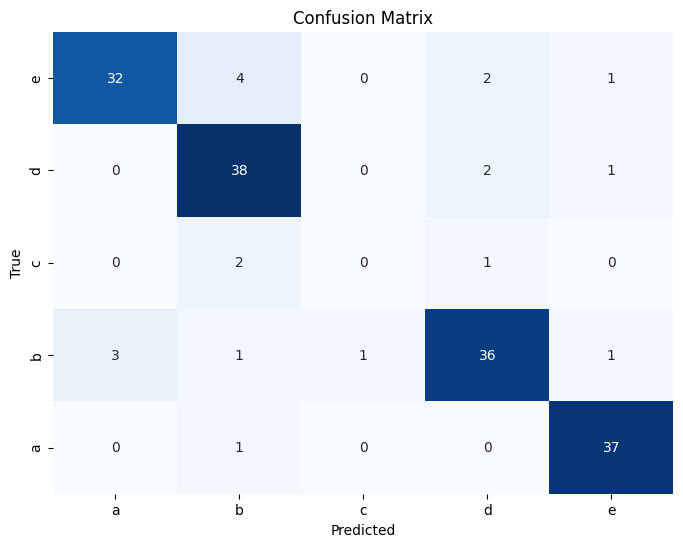

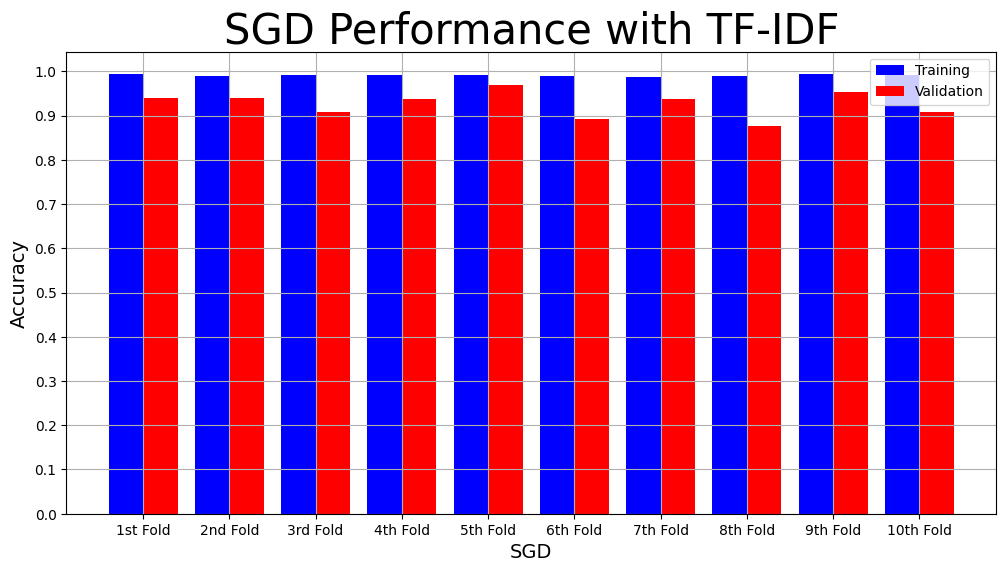

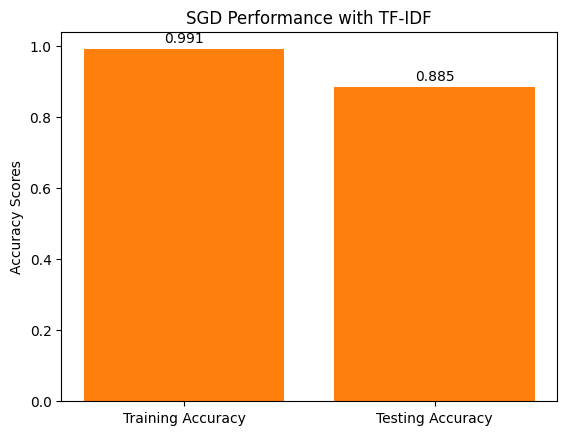

In [39]:
def fit_SGD_with_TFIDF(df):
 
    tfidf_scores=cross_validation(SGDClassifier(loss='hinge', penalty='l2', alpha=0.001,max_iter=1000),
                                  get_tfidf(X_train), y_train, get_tfidf(X_test), y_test, cv=10)
    
    plot_result("SGD", "Accuracy", "SGD Performance with TF-IDF", tfidf_scores['Training Accuracy scores'], 
                tfidf_scores['Validation Accuracy scores'], 0.1)

    plot_accuracy(tfidf_scores['Training Accuracy scores'],
                tfidf_scores['Accuracy Scores'], "SGD Performance with TF-IDF")
 
    return tfidf_scores
 

result_SGD_TFIDF = fit_SGD_with_TFIDF(df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selec

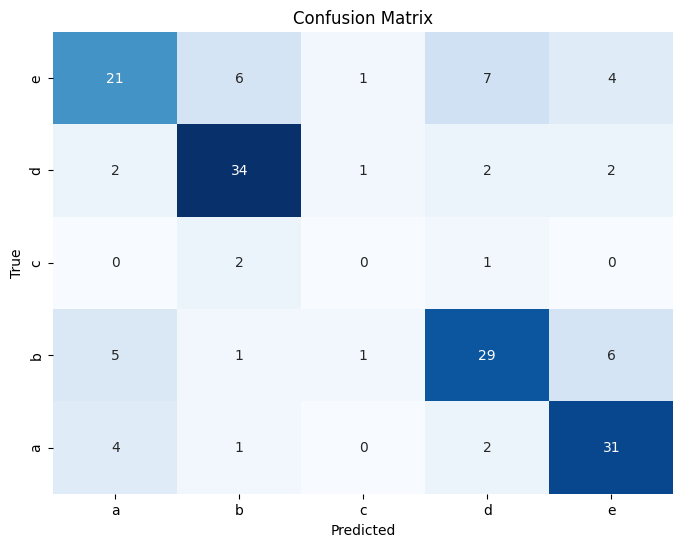

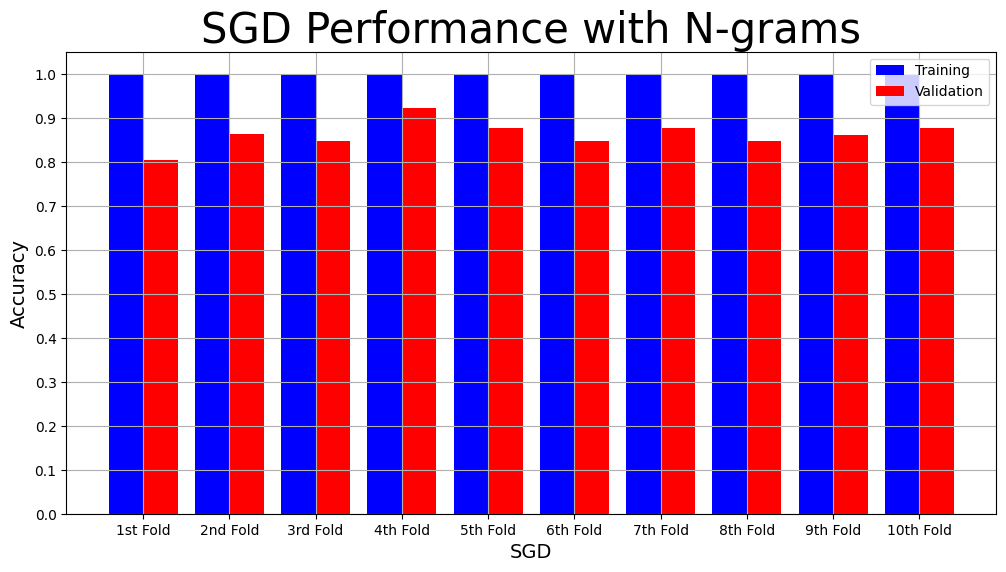

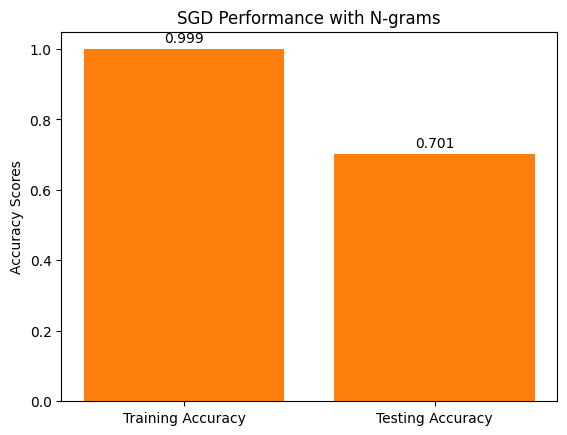

In [41]:
def fit_SGD_with_ngrams(df):
    scores_ngrams=cross_validation(SGDClassifier(loss='hinge', penalty='l2', alpha=0.001,max_iter=1000),
                                   get_ngrams(X_train),y_train, get_ngrams(X_test), y_test, cv=10)
    
    plot_result("SGD", "Accuracy", "SGD Performance with N-grams", scores_ngrams['Training Accuracy scores'], 
                scores_ngrams['Validation Accuracy scores'], 0.1)

    plot_accuracy(scores_ngrams['Training Accuracy scores'],
                scores_ngrams['Accuracy Scores'], "SGD Performance with N-grams")
    
    return scores_ngrams
 

result_SGD_ngrams = fit_SGD_with_ngrams(df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

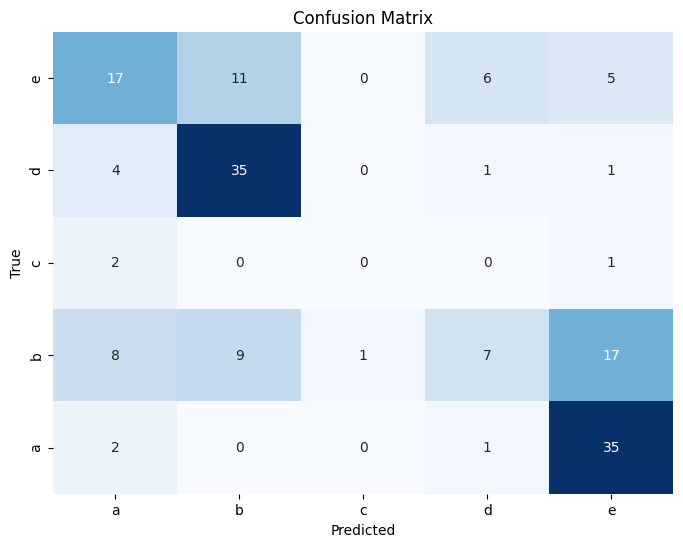

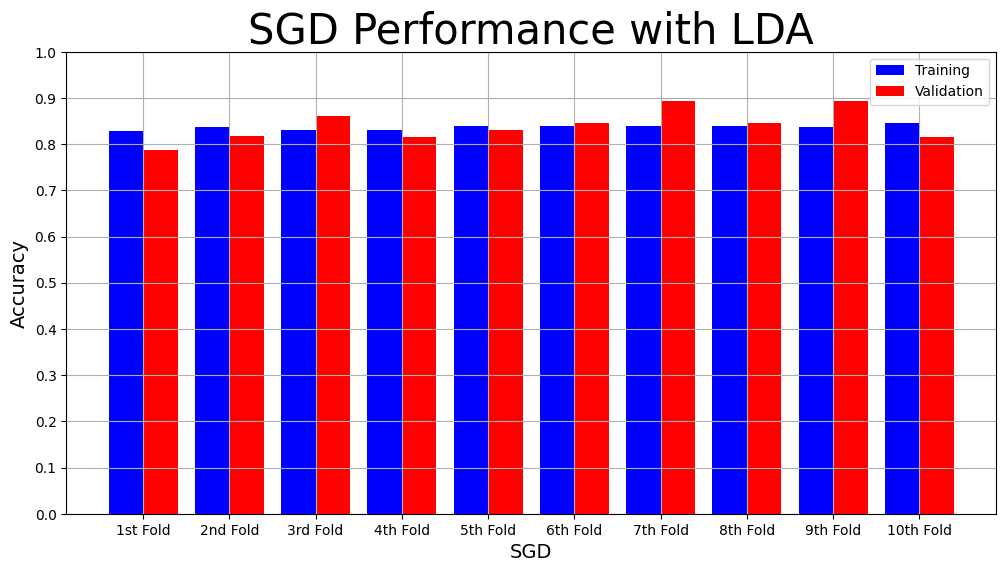

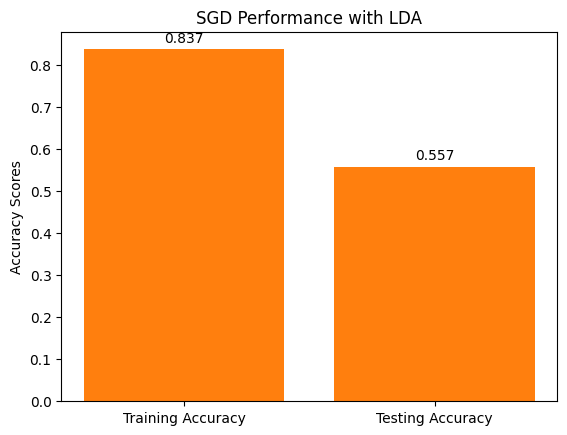

In [42]:
def fit_SGD_with_Lda(df):
    lda_scores=cross_validation(SGDClassifier(loss='hinge', penalty='l2', alpha=0.001,max_iter=1000),
                                get_lda(X_train),y_train, get_lda(X_test), y_test, cv=10)
    
    plot_result("SGD", "Accuracy", "SGD Performance with LDA", lda_scores['Training Accuracy scores'], 
                lda_scores['Validation Accuracy scores'], 0.1)

    plot_accuracy(lda_scores['Training Accuracy scores'],
                lda_scores['Accuracy Scores'], "SGD Performance with LDA")
    
    return lda_scores


result_SGD_lda = fit_SGD_with_Lda(df)

## Magda

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selec

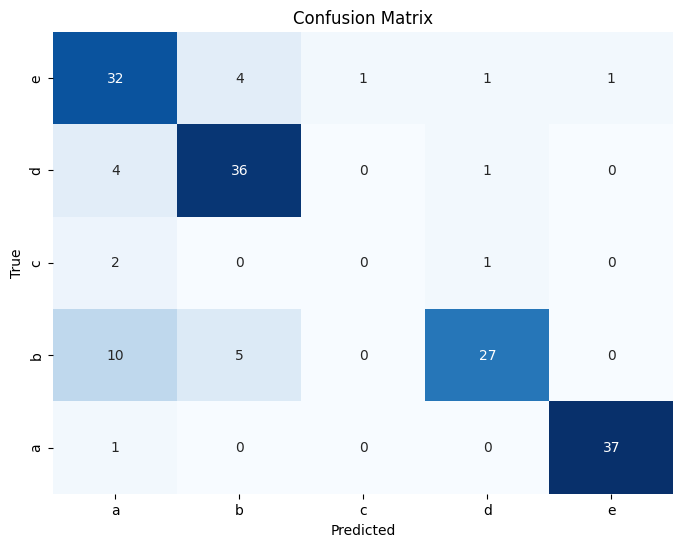

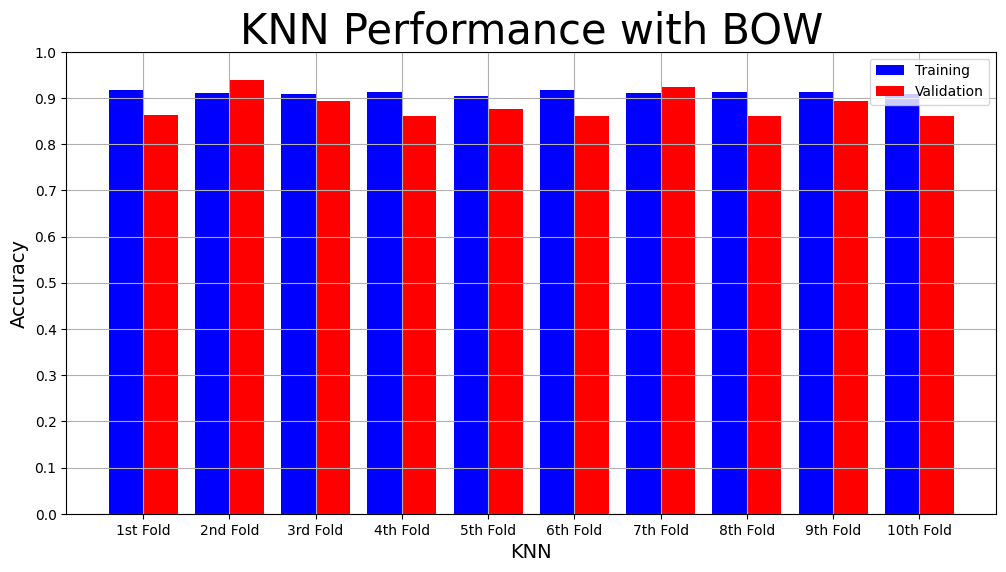

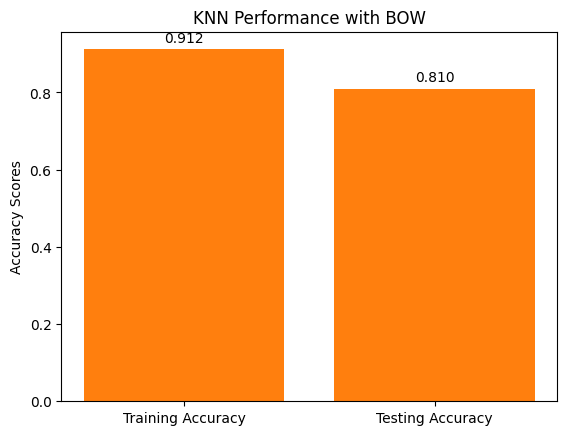

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def KNN_BOW():

    x = get_bow(X_train)
    y = y_train
    # Perform grid search to find the optimal number of neighbors
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': range(1, 10)}  # Specify the range of values to search
    grid_search = GridSearchCV(knn, param_grid, cv=10)
    grid_search.fit(x, y)
    
    # Retrieve the best number of neighbors
    best_n_neighbors = grid_search.best_params_['n_neighbors']
    
    # Train the KNN model with the optimal number of neighbors
    knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    res = cross_validation(knn_model, get_bow(X_train), y_train, get_bow(X_test), y_test, cv=10)

    plot_result("KNN", "Accuracy", "KNN Performance with BOW",
                res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

    plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "KNN Performance with BOW")


    return res

result_knn_bow = KNN_BOW()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.5s finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selec

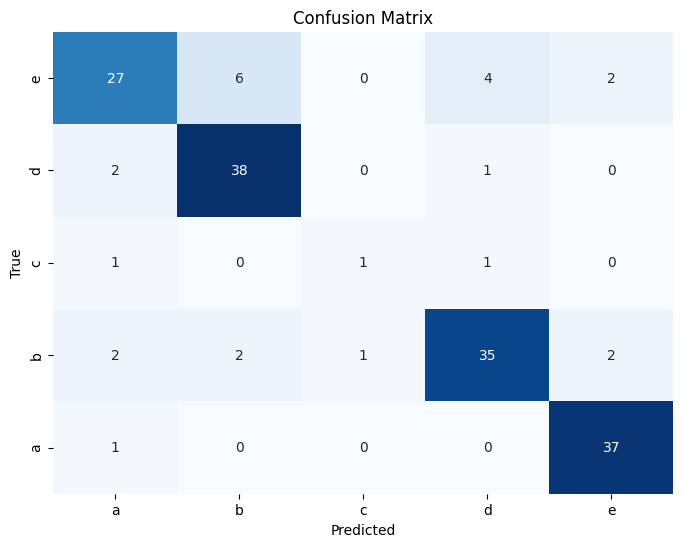

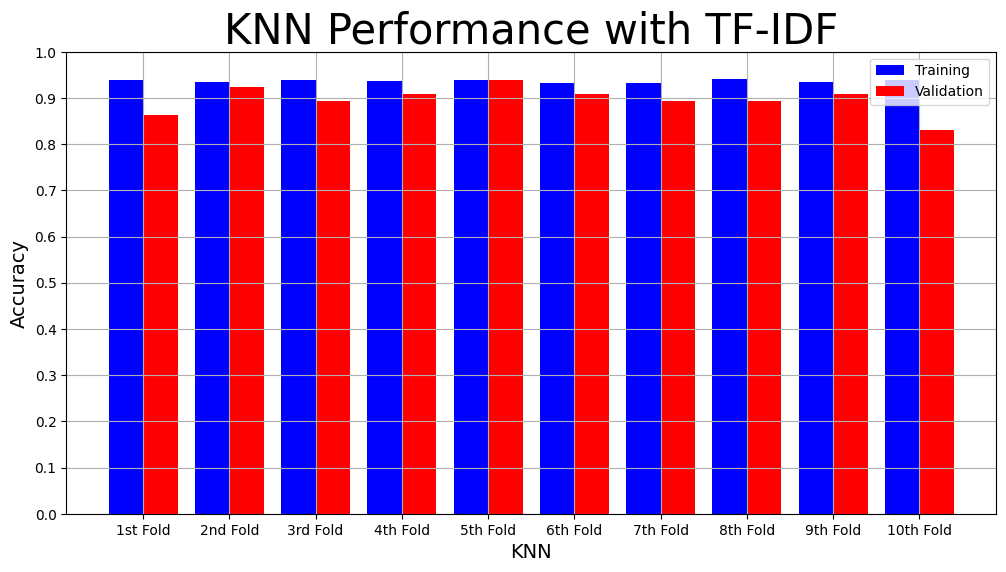

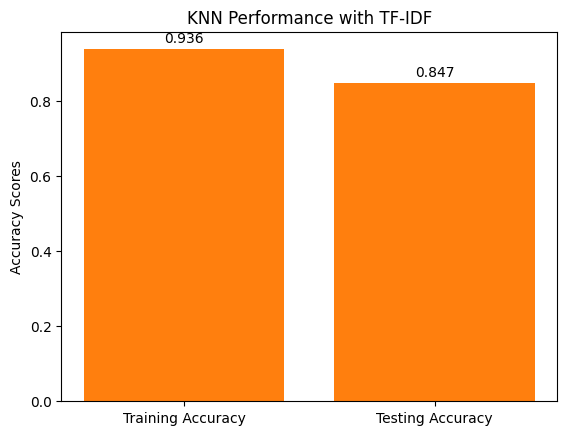

In [50]:
def KNN_tfidf():

    x = get_tfidf(X_train)
    y = y_train
    # Perform grid search to find the optimal number of neighbors
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': range(1, 10)}  # Specify the range of values to search
    grid_search = GridSearchCV(knn, param_grid, cv=10)
    grid_search.fit(x, y)
    
    # Retrieve the best number of neighbors
    best_n_neighbors = grid_search.best_params_['n_neighbors']
    
    # Train the KNN model with the optimal number of neighbors
    knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    res = cross_validation(knn_model, get_tfidf(X_train), y_train, get_tfidf(X_test), y_test, cv=10)
    
    plot_result("KNN", "Accuracy", "KNN Performance with TF-IDF", 
                res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

    plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "KNN Performance with TF-IDF")

    return res

result_knn_tfidf = KNN_tfidf()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

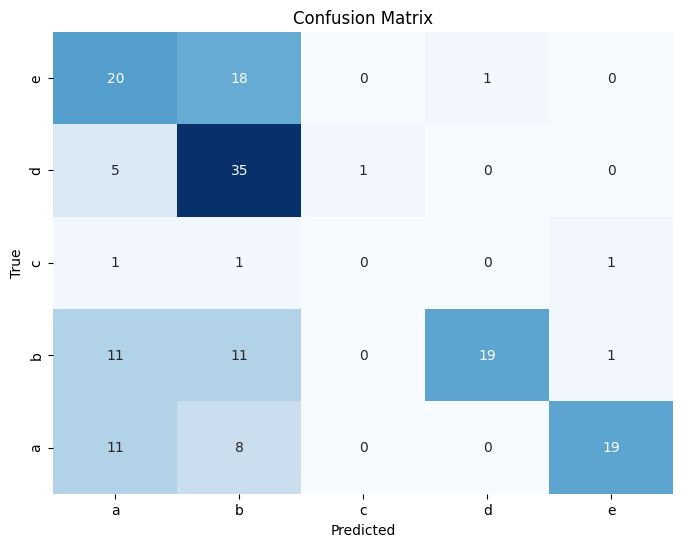

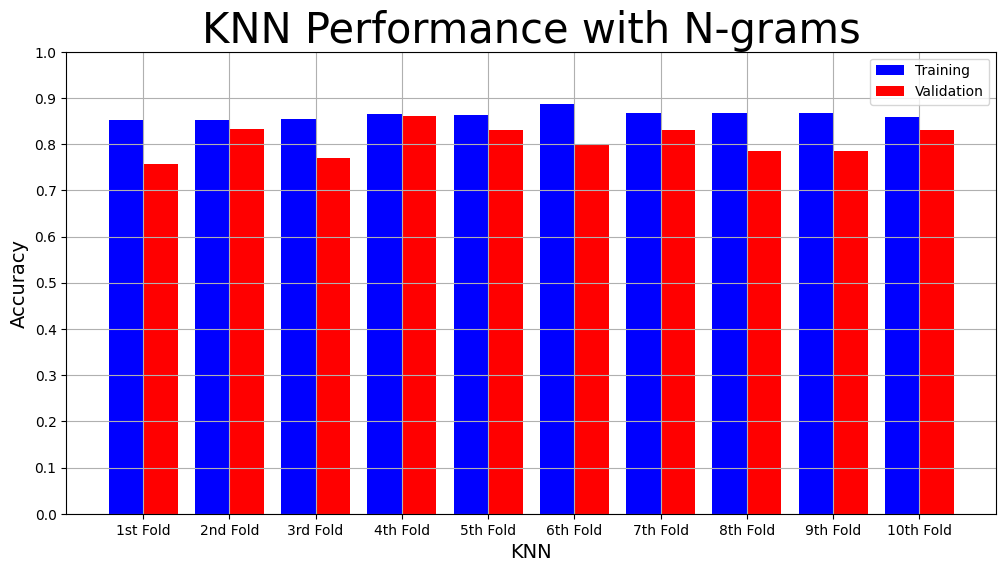

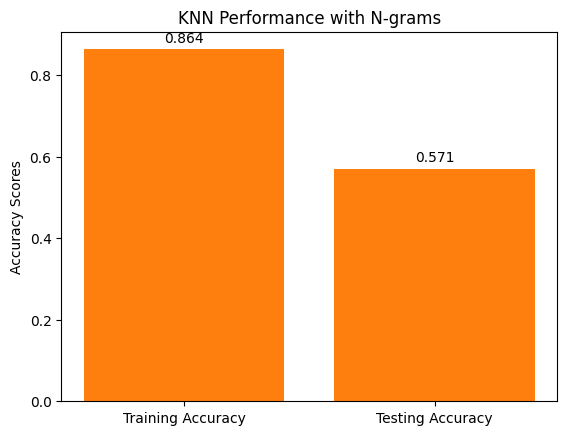

In [51]:
def KNN_ngrams():

    x = get_ngrams(X_train)
    y = y_train

    # Perform grid search to find the optimal number of neighbors
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': range(1, 10)}  # Specify the range of values to search
    grid_search = GridSearchCV(knn, param_grid, cv=10)
    grid_search.fit(x, y)
    
    # Retrieve the best number of neighbors
    best_n_neighbors = grid_search.best_params_['n_neighbors']
    
    # Train the KNN model with the optimal number of neighbors
    knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    res = cross_validation(knn_model, get_ngrams(X_train), y_train, get_ngrams(X_test), y_test, cv=10)
    
    plot_result("KNN", "Accuracy", "KNN Performance with N-grams",
                res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

    plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "KNN Performance with N-grams")

    return res

result_knn_ngrams = KNN_ngrams()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: 

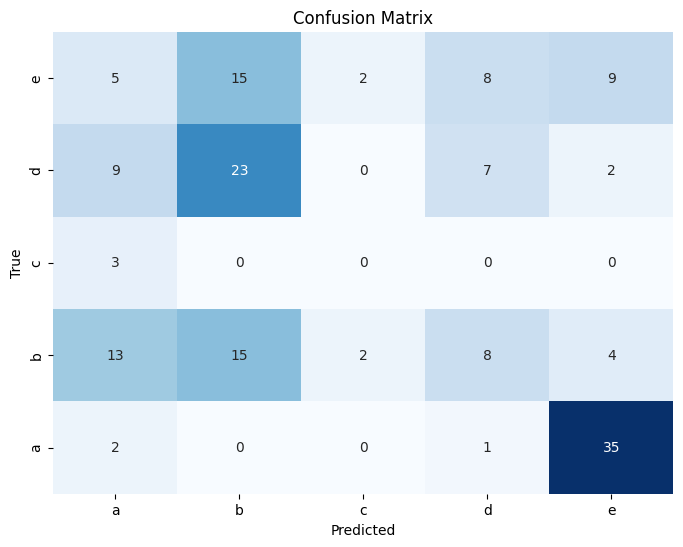

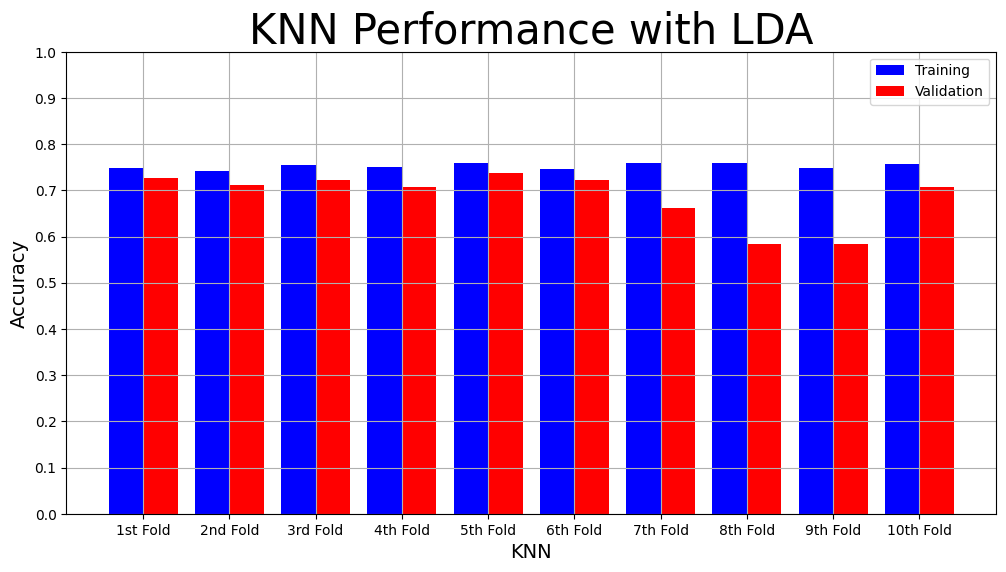

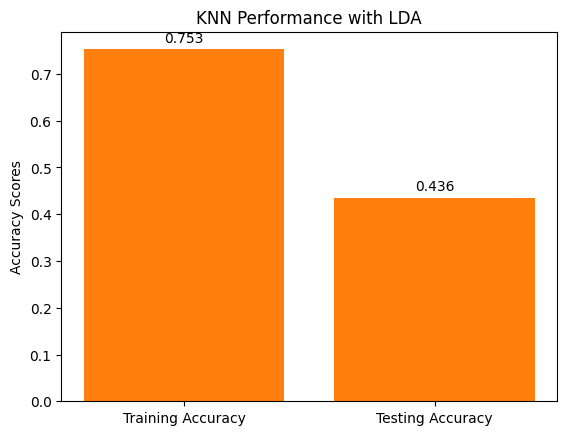

In [52]:
from sklearn.model_selection import GridSearchCV

def KNN_lda():

    x = get_lda(X_train)
    y = y_train

    # Perform grid search to find the optimal number of neighbors
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': range(1, 10)}  # Specify the range of values to search
    grid_search = GridSearchCV(knn, param_grid, cv=10)
    grid_search.fit(x, y)
    
    # Retrieve the best number of neighbors
    best_n_neighbors = grid_search.best_params_['n_neighbors']
    
    # Train the KNN model with the optimal number of neighbors
    knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    res = cross_validation(knn_model, get_lda(X_train), y_train, get_lda(X_test), y_test, cv=10)
    
    plot_result("KNN", "Accuracy", "KNN Performance with LDA",
                res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

    plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "KNN Performance with LDA")
    
    return res

result_knn_lda = KNN_lda()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selec

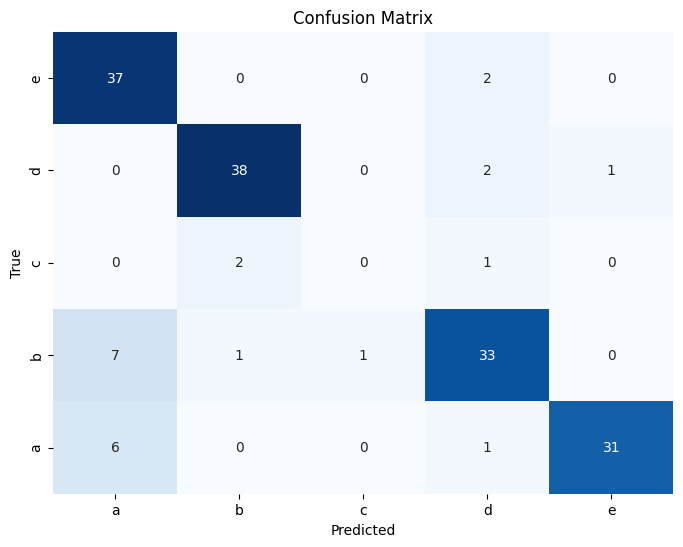

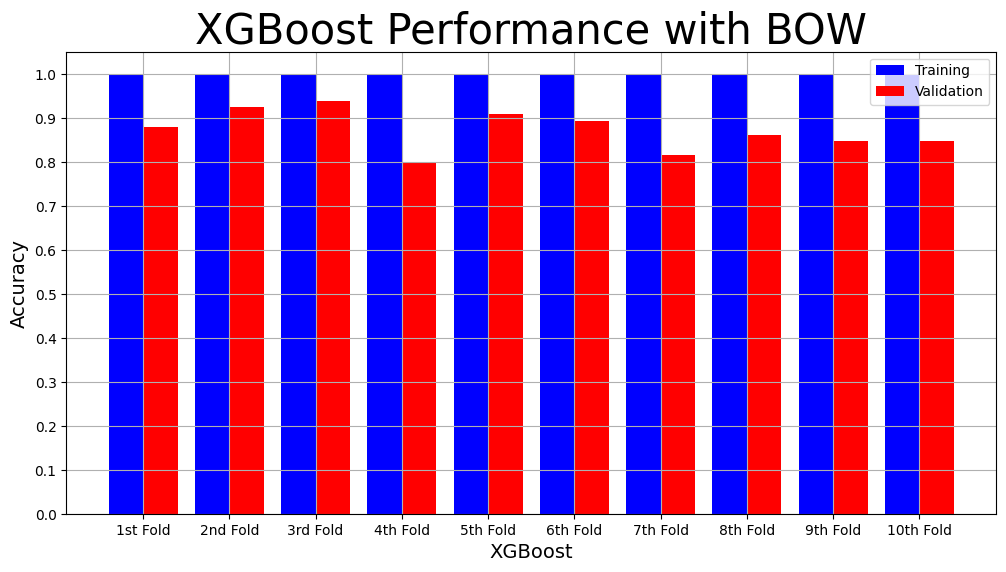

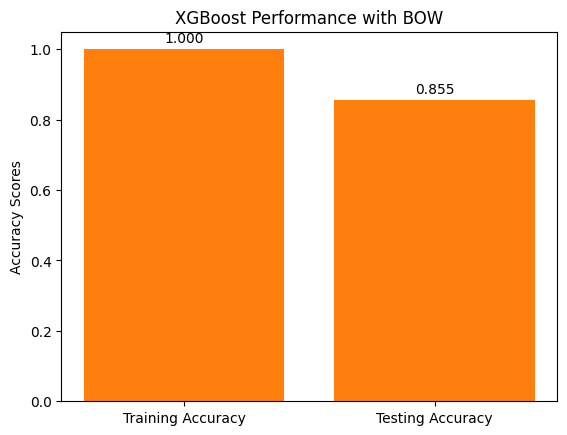

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

def xgboost_BOW():

  res = cross_validation(GradientBoostingClassifier(), get_bow(X_train), y_train, get_bow(X_test), y_test, cv=10)
  
  plot_result("XGBoost", "Accuracy", "XGBoost Performance with BOW", 
                res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

  plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "XGBoost Performance with BOW")
  
  return res
xgboost_BOW_result = xgboost_BOW()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selec

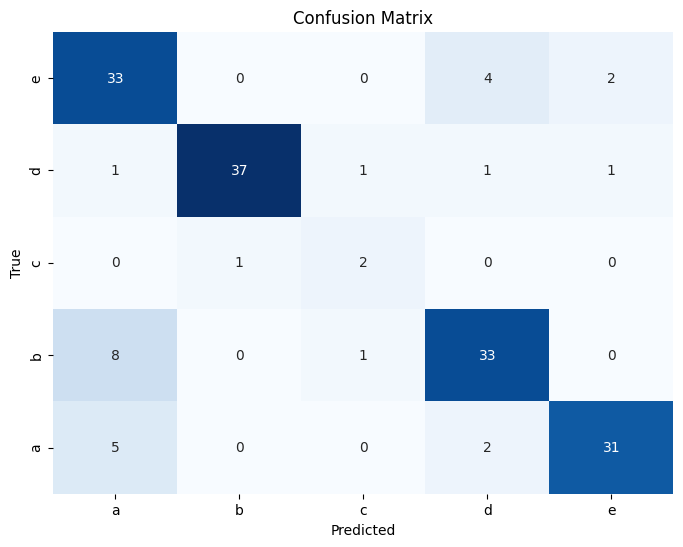

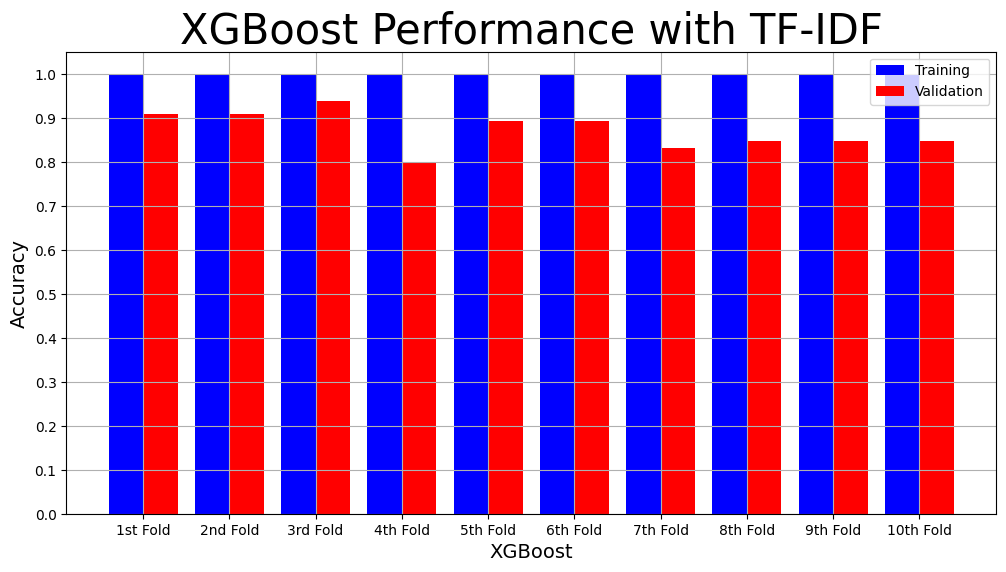

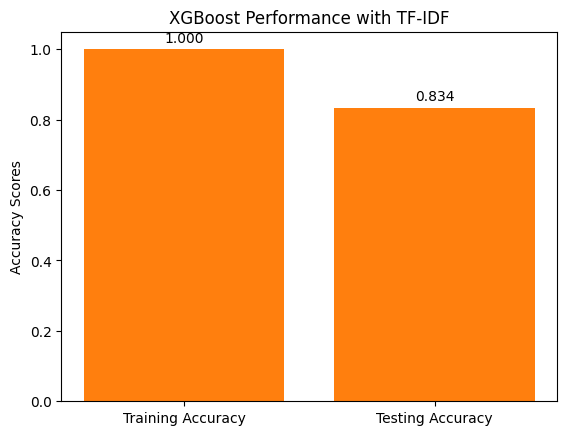

In [60]:
def xgboost_tfidf():

  res = cross_validation(GradientBoostingClassifier(), get_tfidf(X_train), y_train, get_tfidf(X_test), y_test, cv=10)
  
  plot_result("XGBoost", "Accuracy", "XGBoost Performance with TF-IDF",
                    res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

  plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "XGBoost Performance with TF-IDF")

  return res
xgboost_tfidf_result = xgboost_tfidf() 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

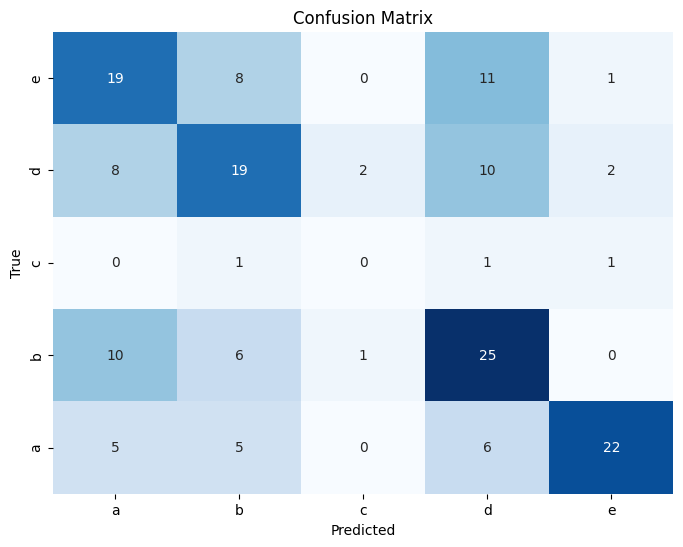

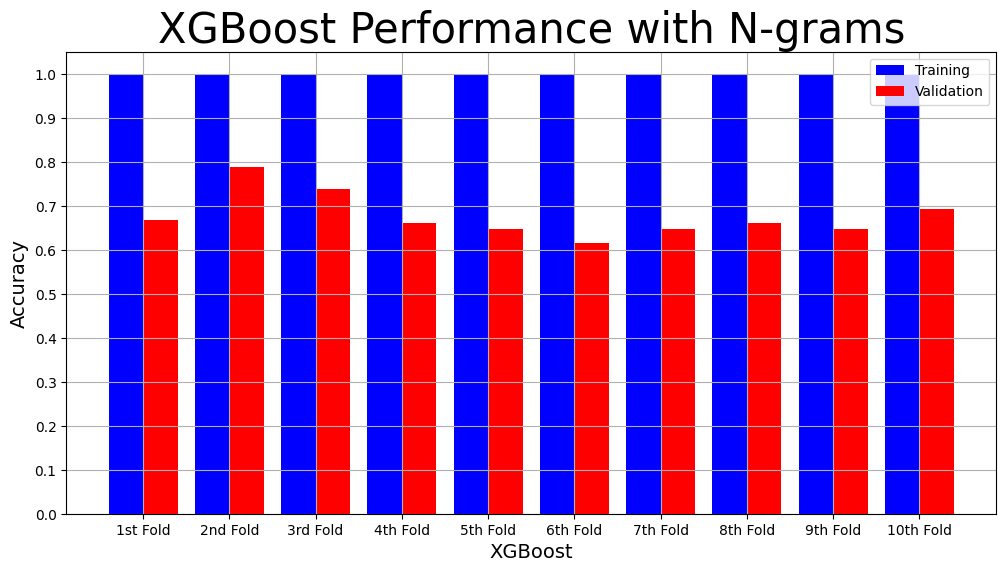

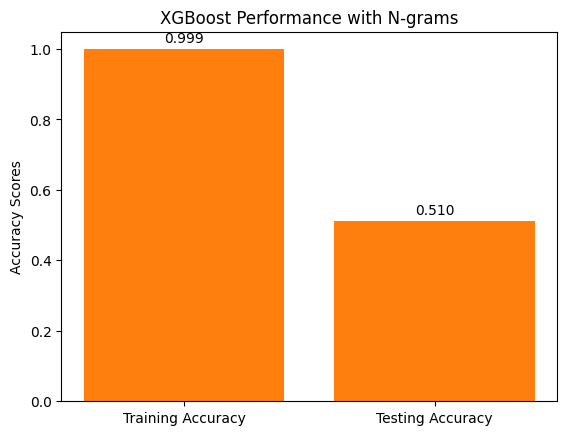

In [59]:
def xgboost_ngrams():

  res = cross_validation(GradientBoostingClassifier(), get_ngrams(X_train), y_train, get_ngrams(X_test), y_test, cv=10)
  
  plot_result("XGBoost", "Accuracy", "XGBoost Performance with N-grams",
                        res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

  plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "XGBoost Performance with N-grams")
  
  return res
xgboost_ngrams_result = xgboost_ngrams()  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.6s finished
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selec

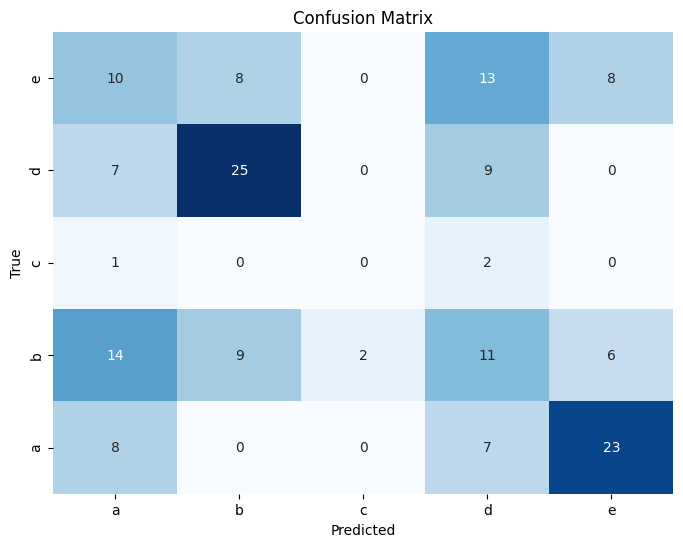

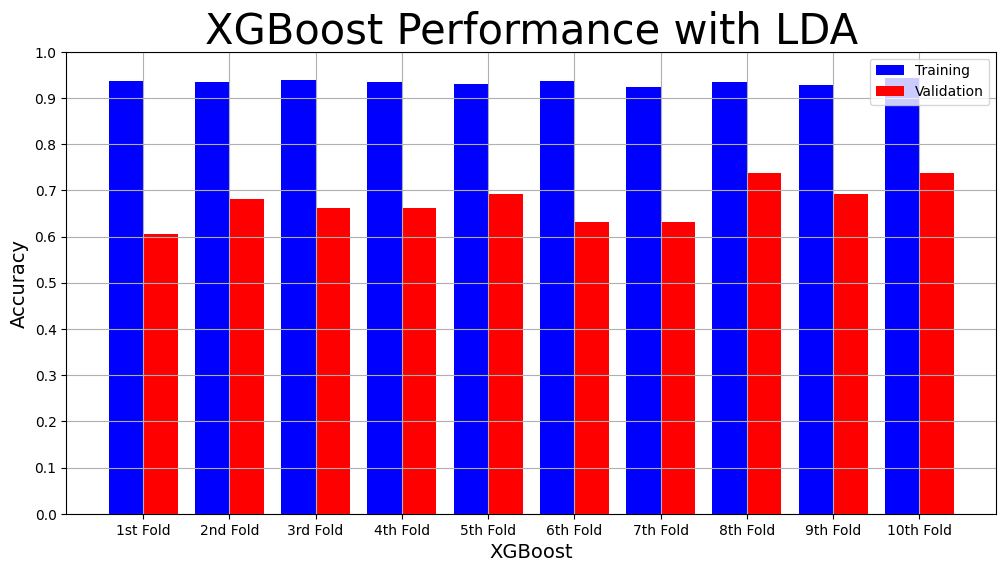

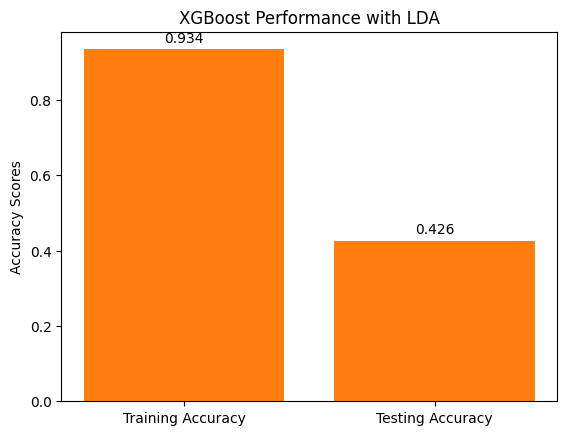

In [58]:
def xgboost_lda():

  res = cross_validation(GradientBoostingClassifier(), get_lda(X_train), y_train, get_lda(X_test), y_test, cv=10)
  
  plot_result("XGBoost", "Accuracy", "XGBoost Performance with LDA",
                            res['Training Accuracy scores'], res['Validation Accuracy scores'], 0.1)

  plot_accuracy(res['Training Accuracy scores'],
                res['Accuracy Scores'], "XGBoost Performance with LDA")
  
  return res
xgboost_lda_result = xgboost_lda()  

In [71]:
all_models_result = {"result_svm_bow": result_svm_bow, "result_svm_tfidf": result_svm_tfidf,        "result_svm_ngram": result_svm_ngram, "result_svm_lda": result_svm_lda,
                     "result_random_forest_bow": result_random_forest_bow, "result_random_forest_tfidf": result_random_forest_tfidf, "result_random_forest_ngrams": result_random, "result_random_forest_lda": result_random_forest_lda,
                     "result_gaussian_nb_bow": result_GaussianNB_BOW, "result_gaussian_nb_tfidf": result_GaussianNB_TFIDF, "result_gaussian_nb_ngrams": result_GaussianNB_ngrams, "result_gaussian_nb_lda": result_GaussianNB_lda,
                     "result_sgd_bow": result_SGD_BOW, "result_sgd_tfidf": result_SGD_TFIDF, "result_sgd_ngrams": result_SGD_ngrams, "result_sgd_lda": result_SGD_lda,
                     "result_knn_bow": result_knn_bow, "result_knn_tfidf": result_knn_tfidf, "result_knn_ngrams": result_knn_ngrams, "result_knn_lda": result_knn_lda,
                     "xgboost_BOW_result": xgboost_BOW_result, "xgboost_tfidf_result": xgboost_tfidf_result, "xgboost_ngrams_result": xgboost_ngrams_result, "xgboost_lda_result": xgboost_lda_result,
                     }

In [72]:
all_models_result

{'result_svm_bow': {'Training Accuracy scores': array([0.98122867, 0.98293515, 0.98807496, 0.98296422, 0.97785349,
         0.98637138, 0.98807496, 0.98807496, 0.98296422, 0.97785349]),
  'Mean Training Accuracy': 98.36395509067334,
  'Training Precision scores': array([0.98571429, 0.9866262 , 0.99066667, 0.98677858, 0.98333333,
         0.98927778, 0.990567  , 0.99066667, 0.98677858, 0.98343949]),
  'Mean Training Precision': 0.9873848583500779,
  'Training Recall scores': array([0.85040752, 0.88539185, 0.92315369, 0.86860824, 0.83087474,
         0.90498132, 0.92315369, 0.93996565, 0.85588096, 0.83313166]),
  'Mean Training Recall': 0.8815549316977045,
  'Training F1 scores': array([0.87622595, 0.91540557, 0.94870605, 0.89781107, 0.85007464,
         0.93363969, 0.94869207, 0.96087473, 0.8834521 , 0.85455415]),
  'Mean Training F1 Score': 0.906943602940682,
  'Validation Accuracy scores': array([0.90909091, 0.93939394, 0.92307692, 0.90769231, 0.93846154,
         0.89230769, 0.923076

In [73]:
df = pd.DataFrame(all_models_result)

df.to_pickle("all_models_result.pkl")

In [93]:
df['result_sgd_tfidf']['Mean Validation Accuracy']

92.63403263403264

In [94]:
df = pd.read_pickle('all_models_result.pkl')

In [95]:
def plot_train_test_accuracy(title, train_data, test_data):
    # Generate model labels
    models = [f"Model {i + 1}" for i in range(len(train_data))]

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(models, train_data, marker='o', label='Training Accuracy')
    plt.plot(models, test_data, marker='o', label='Test Accuracy')
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

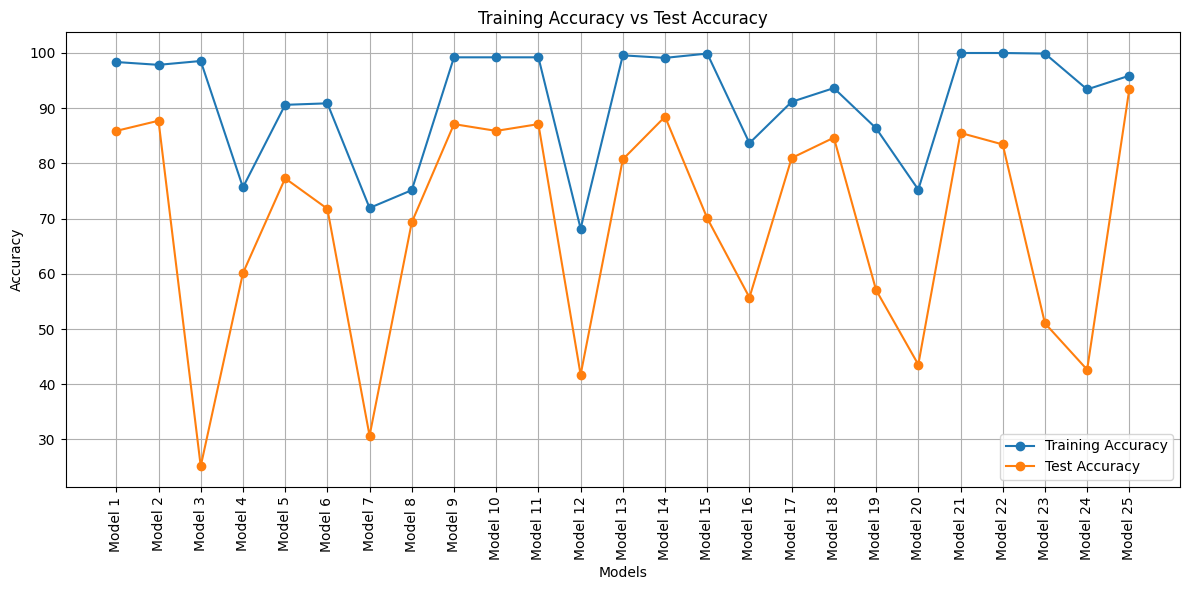

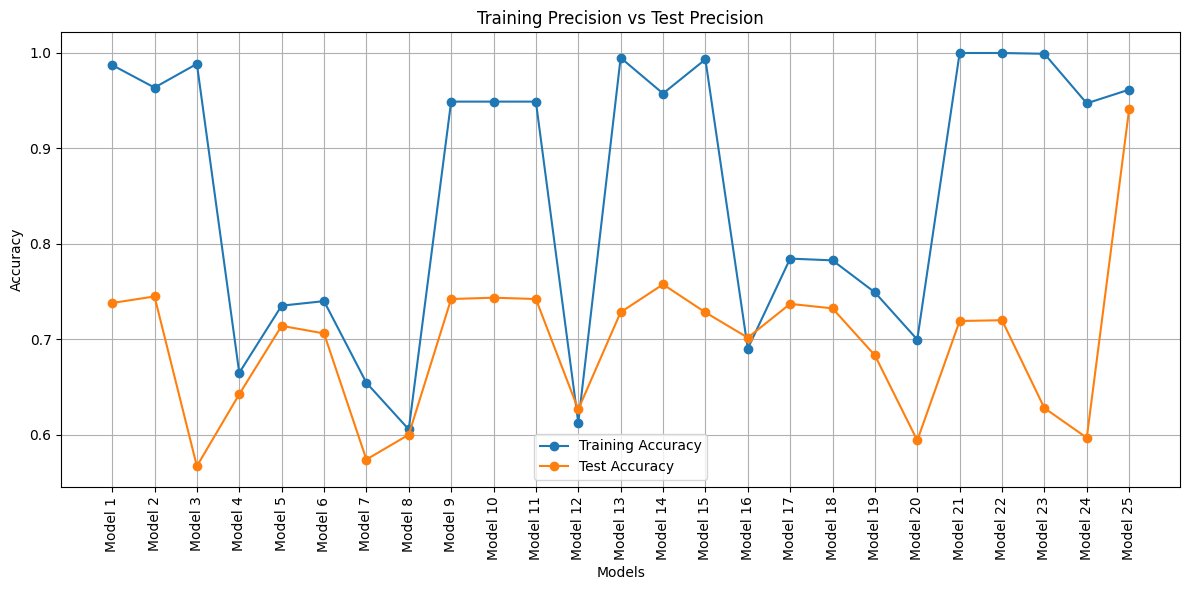

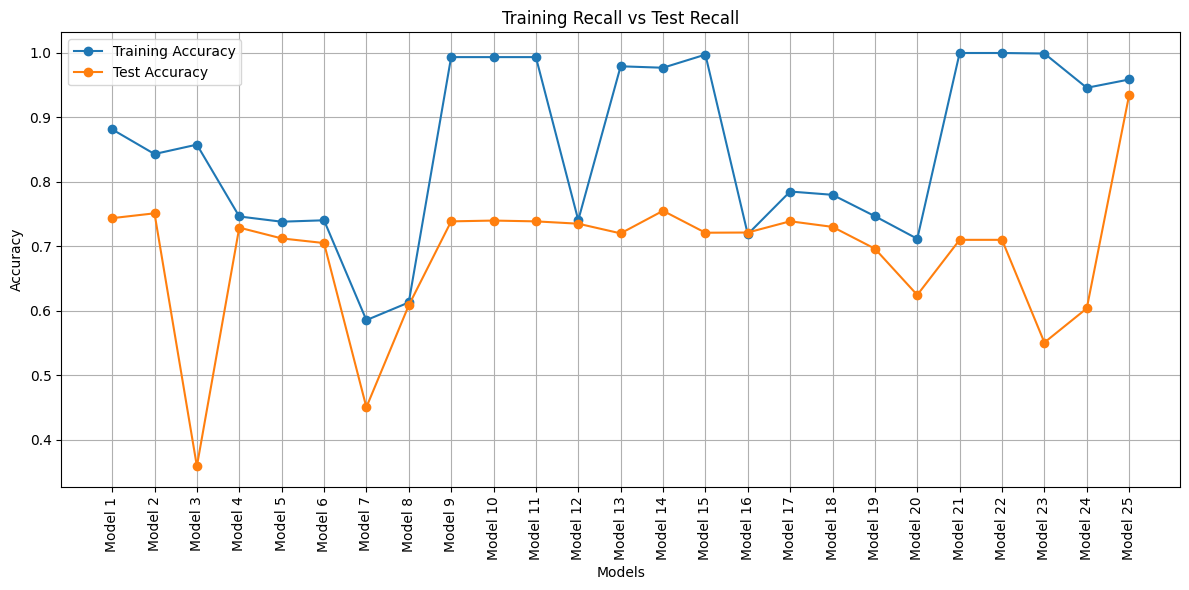

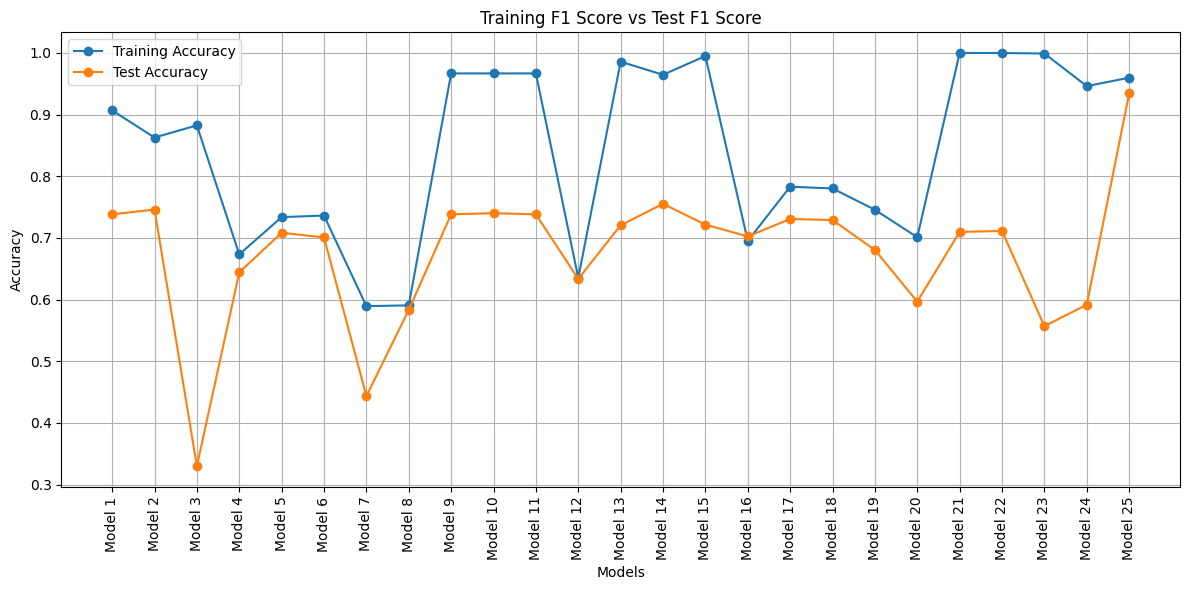

In [96]:
train_acc = df.iloc[1, :].tolist()
train_acc.append(95.89)
train_precision = df.iloc[3, :].tolist()
train_precision.append(0.9616)
train_recall = df.iloc[5, :].tolist()
train_recall.append(0.9589)
train_f1 = df.iloc[7, :].tolist()
train_f1.append(0.9599)
test_acc = [np.mean(x) * 100 for x in df.loc['Accuracy Scores', :].values.tolist()]
test_acc.append(93.49)
test_precision = df.iloc[11, :].tolist()
test_precision.append(0.9412)
test_recall = df.iloc[13, :].tolist()
test_recall.append(0.9349)
test_f1 = df.iloc[15, :].tolist()
test_f1.append(0.9344)


plot_train_test_accuracy("Training Accuracy vs Test Accuracy", train_acc, test_acc)
plot_train_test_accuracy("Training Precision vs Test Precision", train_precision, test_precision)
plot_train_test_accuracy("Training Recall vs Test Recall", train_recall, test_recall)
plot_train_test_accuracy("Training F1 Score vs Test F1 Score", train_f1, test_f1)